In [ ]:
############ Create the first part of simple interloper effect
############ Write all the useful functions that convert from lenstronomy variables to theory variables
##### USE clean_lenstronomy_notebook as reference

In [1]:
# some standard python imports #
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cms
%matplotlib inline

from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
import lenstronomy.Plots.output_plots as lens_plot
from lenstronomy.LightModel.light_model import LightModel
import lenstronomy.Util.param_util as param_util
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.psf import PSF
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

In [2]:
def ADD(z1,z2):
    ## This is a function that computes the angular diameter distance
    ## between two redshifts z1 and z2.
    cosmo = FlatLambdaCDM(H0=70, Om0=0.316) 
    return cosmo.angular_diameter_distance_z1z2(z1,z2)

def sigma_cr(zd,zs):
    ## This function calculates the critical surface mass density at
    ## redshift zd, relative to the source redshift zs.
    const = 1.663e18*u.M_sun / u.Mpc##c^2/(4 pi G)
    return const*(ADD(0,zs)/(ADD(zd,zs)*ADD(0,zd))) ##in units Msun/Mpc^2

def gfunc(c):
    ## This is the g(c) function that is defined
    ## commonly in NFW profiles.
    a = np.log(1.+c) - (c/(1.+c))
    return 1./a

def rs_angle(zd,rs): 
    ##takes in interloper redshift, scale redius, gives you the scale redius in angular units
    Dd = ADD(0,zd)
    rs_mpc = rs*u.Mpc
    return ((1./4.848e-6)*rs_mpc)/Dd ##gives in arcsec

def alpha_s(m,rs,zd,zs):
    ##takes in subhalo mass, scale radius, interloper redshift, source redshift
    ##returns the angular deflection at scale radius
    Dd = ADD(0,zd)
    m_msun = m*u.M_sun
    rs_mpc = rs*u.Mpc
    con = (1./np.pi)*gfunc(200.)*(1.-np.log(2))
    return (1/4.848e-6)*(con*m_msun)/((rs_mpc*Dd)*sigma_cr(zd,zs))


def k_ext(N,m,A,zd,zs,pixsize):
    ## FOR NOW THIS IS SET TO ZERO BECAUSE I CAN'T GET IT TO WORK
    m_msun = m*u.M_sun
    A_mpc2 = (pixsize**4)*(ADD(0.,zd)**2.)*A*((4.848e-6)**2.)  ##arcsec conversion
    return 0.##-(N*m_msun)/(A_mpc2*sigma_cr(zd,zs))

def xi_to_x(xi,z):
    ##takes in physical coordinates (Mpc), turns it into angular coordinates (arcsec)
    x = np.array(((xi*u.Mpc)/ADD(0.,z))/4.848e-6)
    y = x.astype(np.float)
    return y

def x_to_xi(x,z):
    ##takes in angular coordinates (arcsec), turns it into physical coordinates (Mpc)
    return ((x*4.848e-6)*ADD(0,z))/u.Mpc

def xi_to_pix(xi,z,pixsize,pixnum):
    return (xi_to_x(xi,z))/pixsize + pixnum/2.


def rein(M,zl,zs):
    ## calculates Einstein radius
    A = ((M/10.**11.09)**0.5)*((ADD(zl,zs)/(ADD(0,zl)*(ADD(0,zs))))*(1000*u.Mpc))**0.5
    return A

In [3]:
### let us define a function that will create the things we need taking in a imagesz
def imstats(imagesz):
    minbin = 0.
    maxbin = 2000.
    numbin = 200
    
    
    shp = np.shape(imagesz)
    im0 = imagesz[0][0]## the first image is the massless one
    imsub = imagesz[int(shp[0]/5)]##this is the one with substructure
    
    his0,binz0, _ = pixhist(im0,minbin,maxbin,numbin)
    diffss = []
    stdss = []
    meanss = []
    sqrmeanss = []
    
    hissqrmeanses = []
    hisses = []
    for i in range(shp[0]):
        hiss = []
        hissqrmeans = []
        
        diffs = []
        stds = []
        means = []
        sqrmeans = []
        for j in range(shp[1]):
            hisa,binza, _ = pixhist(imagesz[i][j],minbin,maxbin,numbin)
            hisdiff = (hisa - his0)**2.
            hissqrmeans.append(np.mean(hisdiff))
            hiss.append(hisdiff)
            
            diff = imagesz[i][j] - im0
            
            difshp = np.shape(diff)
            ##### masking the center pixels
            SM = 10#### mask size
            
            for l in range(difshp[0]):
                for k in range(difshp[1]):
                    metric = (l - (difshp[0]/2.)- 0.5)**2. + (k - (difshp[1]/2.-0.5))**2.  
                    if metric < SM:
                        diff[l][k] = 0#None
                        
            
            stds.append(np.std(diff))
            means.append(np.mean(diff))
            sqrmeans.append(np.mean(diff**2.))
            diffs.append(diff)
            
        hisses.append(hiss)
        hissqrmeanses.append(hissqrmeans)
        
        diffss.append(diffs)
        stdss.append(stds)
        meanss.append(means)
        sqrmeanss.append(sqrmeans)
    ##stdss is the standard deviation of the residue
    ##meanss is the mean of the residue
    ##sqrmean is the square mean of the residue
    ##diffss are the residue maps
    ##hisses are the pixel value histograms
    ##hisssqrmeanses is the histogram residue mean squares
    return stdss,meanss,sqrmeanss,diffss,hisses,hissqrmeanses


def pixhist(image,minbin,maxbin,numbin):
    flatt = np.ndarray.flatten(image)
    bins = np.linspace(minbin,maxbin,numbin+1)
    his,binz = np.histogram(image,bins)
    return his,binz,flatt

In [13]:
## REDSHIFTS #######################################################################################
Nit = 50 #Number of different redshifts

zds = np.linspace(0.01,0.99,int(Nit))

In [74]:
## REDSHIFTS #######################################################################################
Nit = 50 #Number of different redshifts

zds = np.linspace(0.01,0.99,int(Nit))

## SOURCE PROPERTIES ###############################################################################
r_sersic_source = 10.0
e1s, e2s = param_util.phi_q2_ellipticity(phi=0.8, q=0.4)
beta_ras, beta_decs = [0.7],[0.3]#this is the source position on the source plane

## SOURCE-CLUMP PROPERTIES #########################################################################
r_sersic_source_clumps = 0.5
N_clump = 0
clumprandx = np.random.rand(N_clump)
clumprandy = np.random.rand(N_clump)

source_scatter = 1. ## This is how wide the scatter of the clumps over the smooth source

####################################################################################################



## LENS PROPERTIES #################################################################################
theta_lens = 6.
zl = 0.2
r_theta_lens = x_to_xi(theta_lens,zl)
e1, e2 = param_util.phi_q2_ellipticity(phi=-0.9, q=0.9)
gamma = 2.

center_lens_x, center_lens_y = 0.,0.
####################################################################################################



## IMAGE PROPERTIES ################################################################################
pixsize = 0.2
####################################################################################################



## INTERLOPER PROPERTIES ########################################################################### 
N = 60 ##Number of perturbers
M = 100 ##Averaging different realizations

disc_size = 2. ##  interlopers are randomly distributed to a disk that is this
               ##  this times bigger than the einstein radius of the lens
r2s = ((disc_size*r_theta_lens)**2.)*(np.random.rand(N,M))
rss = np.sqrt(r2s)
theta_p = 2.*np.pi*(np.random.rand(N,M))
xs = rss*np.cos(theta_p)
ys = rss*np.sin(theta_p)
xpixs = np.zeros([Nit,N,M])
ypixs = np.zeros([Nit,N,M])
####################################################################################################


## SUBSTRUCTURE PROPERTIES ########################################################################### 
L = 0 ##Number of perturbers

disc_size_sub = 10. ##  interlopers are randomly distributed to a disk that is this
               ##  this times bigger than the einstein radius of the lens
r2s_sub = ((disc_size_sub*r_theta_lens)**2.)*(np.random.rand(L,M))
rss_sub = np.sqrt(r2s_sub)
theta_p_sub = 2.*np.pi*(np.random.rand(L,M))
xs_sub = rss_sub*np.cos(theta_p_sub)
ys_sub = rss_sub*np.sin(theta_p_sub)
xpixs_sub = np.zeros([L,M])
ypixs_sub = np.zeros([L,M])
####################################################################################################


data_header = []
data_header.append('Number of redshifts/interlopers/random_realizations/subhalos/disc_size: '
                   +str(Nit)+'/'
                  +str(N)+'/'
                  +str(M)+'/'
                  +str(L)+'/'
                  +str(disc_size))
data_header.append('Source N_clump/clump_r_sersic/r_sersic/e1/e2/betara/betadec: ' 
                   + str(N_clump) +'/'
                   + str(r_sersic_source_clumps) + '/'
                   + str(r_sersic_source) + '/'
                  + str(e1s) + '/'
                  + str(e2s) + '/'
                  + str(beta_ras) + '/'
                  + str(beta_decs))
data_header.append('Lens theta/zl/e1/e2/gamma: '
                  + str(theta_lens)+ '/'
                  + str(zl)+ '/'
                  + str(e1)+ '/'
                  + str(e2)+ '/'
                  + str(gamma))

print(data_header)

['Number of redshifts/interlopers/random_realizations/subhalos/disc_size: 50/60/100/0/2.0', 'Source N_clump/clump_r_sersic/r_sersic/e1/e2/betara/betadec: 0/0.5/10.0/-0.012514080986266636/0.42838868701778793/[0.7]/[0.3]', 'Lens theta/zl/e1/e2/gamma: 6.0/0.2/-0.011958004983846688/-0.05125513846727342/2.0']


In [75]:
imagesz = []  ##This will be the main list that all the images that are created are added
              ##at the end it will have the shape (Number of redshifts, Number of statistics,x-Pix,y-Pix)
for j in range(Nit): ## FIRST LOOP IS OVER THE REDSHIFTS
    
    imagesM = []  ## this is a sub-list of imagesz that will be of shape (Number of statistics,x-Pix,y-Pix)
    
    xpixs[j] = xi_to_pix(xs,zds[j],pixsize,100)   ## AT THAT REDSHIFT CALCULATING THE INTERLOPER
    ypixs[j] = xi_to_pix(ys,zds[j],pixsize,100)   ## POSITIONS. (THEY ARE RANDOMLY GENERATED IN THE EARLIER BOX)

    for k in range(M):   ## SECOND LOOP IS OVER THE STATISTICS
        m =1.0e7#ms[j]
        if j == 0:
            m = 0.
        zs = 1.
        zd = zds[j]##0.5
        rs = 0.001
        A = 80**2 ## in arcsec ## IGNORE THIS, THIS WAS FOR NEGATIVE CONVERGENCE
        pixsize = 0.2
        
        

        kext = float(k_ext(N,m,A,zl,zs,pixsize))
        rsang = float(rs_angle(zd,rs))
        alphars = float(alpha_s(m,rs,zd,zs))
 
        m_sub = 1.0e7
        if j == 1:
            m_sub = 0.
        rsang_sub = float(rs_angle(zl,rs))
        alphars_sub = float(alpha_s(m_sub,rs,zl,zs))
        

        ## Setting lens_model_list and redshift_list
        lens_model_main = ['SPEMD'] + ['NFW' for i in range(int(L))]
        lens_model_interlopers = ['CONVERGENCE']+['NFW' for i in range(int(N))]
        redshift_main = [zl]+[zl for i in range(int(L))]
        redshift_interlopers = [zd]+[zd for i in range(int(N))]
        # (unfortunately, we need to give the redshifts in increasing order, so we have two cases)
        if zl >= zd:
            lens_model_list = lens_model_interlopers + lens_model_main
            redshift_list = redshift_interlopers + redshift_main
        else:
            lens_model_list = lens_model_main + lens_model_interlopers
            redshift_list = redshift_main + redshift_interlopers
      
        
        z_source = zs
    
        lensModel_mp = LensModel(lens_model_list=lens_model_list,
                              z_source=z_source, lens_redshift_list=redshift_list, 
                              multi_plane=True)

        kwargs_spep = {'theta_E': theta_lens, 'e1': e1, 'e2': e2, 
                       'gamma': gamma, 'center_x': center_lens_x, 'center_y': center_lens_y}
        kwargs_conv ={'kappa_ext': kext}

        ### We populate interlopers as random SIS distribution
        kwargs_main_lens = [kwargs_spep]
        
        kwargs_subs = []
        for i in range(int(L)):
            center_sis_x = xi_to_x(xs_sub[i,k],zd)
            center_sis_y = xi_to_x(ys_sub[i,k],zd)
            
            kwargs_sis = {'Rs':rsang_sub,'alpha_Rs':alphars_sub,'center_x': center_sis_x, 'center_y': center_sis_y}
            ##param_names = ['Rs', 'alpha_Rs', 'center_x', 'center_y']
            kwargs_subs.append(kwargs_sis)
        
        
        kwargs_interlopers = [kwargs_conv]
        for i in range(int(N)):
            center_sis_x = xi_to_x(xs[i,k],zd)
            center_sis_y = xi_to_x(ys[i,k],zd)
            
            kwargs_sis = {'Rs':rsang,'alpha_Rs':alphars,'center_x': center_sis_x, 'center_y': center_sis_y}
            ##param_names = ['Rs', 'alpha_Rs', 'center_x', 'center_y']
            kwargs_interlopers.append(kwargs_sis)
        
        # (again, need to sort by redshift)
        if zl >= zd:
            kwargs_lens = kwargs_interlopers + kwargs_main_lens + kwargs_subs
        else:
            kwargs_lens = kwargs_main_lens + kwargs_subs + kwargs_interlopers
        # image plane coordinate #
        beta_ra, beta_dec = beta_ras[0],beta_decs[0]#0.,0.#0.03425921, 0.012145

        solver = LensEquationSolver(lensModel_mp)
        theta_ra, theta_dec = solver.image_position_from_source(beta_ra, beta_dec, kwargs_lens)

        mag = lensModel_mp.magnification(theta_ra, theta_dec, kwargs_lens)
        dt = lensModel_mp.arrival_time(theta_ra, theta_dec, kwargs_lens)
        ########################################################################
        # set up the list of light models to be used #
        source_light_model_list = ['SERSIC_ELLIPSE']
        
        
        for i in range(N_clump):
            source_light_model_list.append('SERSIC')
        
        lightModel_source = LightModel(light_model_list=source_light_model_list)
        lens_light_model_list = ['SERSIC_ELLIPSE']
        lightModel_lens = LightModel(light_model_list=lens_light_model_list)
        # define the parameters #
#        kwargs_light_source = [{'amp': 1000, 'R_sersic': r_sersic_source , 'n_sersic': 1.5, 
#                                'center_x': beta_ra, 'center_y': beta_dec}]
        
        kwargs_light_source = [{'amp': 2500., 'R_sersic': r_sersic_source, 'n_sersic': gamma, 
                              'e1': e1s, 'e2': e2s, 'center_x': beta_ra , 'center_y': beta_dec}]
        
        for i in range(N_clump):
            kwargs_light_source.append({'amp': 1000, 'R_sersic': r_sersic_source/30. , 'n_sersic': 1.5, 
                                'center_x': beta_ra+source_scatter*(clumprandx[i]-.5), 
                                        'center_y': beta_dec+source_scatter*(clumprandy[i]-.5)})
        
        
        kwargs_light_lens = [{'amp': 3500, 'R_sersic': 2.*theta_lens, 'n_sersic': gamma, 
                              'e1': e1, 'e2': e2, 'center_x': center_lens_x , 'center_y': center_lens_y}]

        # evaluate surface brightness at a specific position #
        flux = lightModel_lens.surface_brightness(x=1, y=1, kwargs_list=kwargs_light_lens)

        
        deltaPix = pixsize ###aLSO PIXSIze size of pixel in angular coordinates #

        # setup the keyword arguments to create the Data() class #
        ra_at_xy_0, dec_at_xy_0 = -10, -10 # coordinate in angles (RA/DEC) at the position of the pixel edge (0,0)
        transform_pix2angle = np.array([[1, 0], [0, 1]]) * deltaPix  # linear translation matrix of a shift in pixel in a shift in coordinates
        kwargs_pixel = {'nx': 100, 'ny': 100,  # number of pixels per axis
                        'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                        'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                        'transform_pix2angle': transform_pix2angle} 
        pixel_grid = PixelGrid(**kwargs_pixel)
        # return the list of pixel coordinates #
        x_coords, y_coords = pixel_grid.pixel_coordinates
        # compute pixel value of a coordinate position #
        x_pos, y_pos = pixel_grid.map_coord2pix(ra=0, dec=0)
        # compute the coordinate value of a pixel position #
        ra_pos, dec_pos = pixel_grid.map_pix2coord(x=20, y=10)

        # import the PSF() class #
        
        kwargs_psf = {'psf_type': 'GAUSSIAN',  # type of PSF model (supports 'GAUSSIAN' and 'PIXEL')
                      'fwhm': 0.01,  # full width at half maximum of the Gaussian PSF (in angular units)
                      'pixel_size': deltaPix  # angular scale of a pixel (required for a Gaussian PSF to translate the FWHM into a pixel scale)
                     }
        psf = PSF(**kwargs_psf)
        # return the pixel kernel correspon
        kernel = psf.kernel_point_source

        ####################################################################################

        # import the ImageModel class #
        
        # define the numerics #
        kwargs_numerics = {'supersampling_factor': 1, # each pixel gets super-sampled (in each axis direction) 
                          'supersampling_convolution': False}
        # initialize the Image model class by combining the modules we created above #
        imageModel = ImageModel(data_class=pixel_grid, psf_class=psf, lens_model_class=lensModel_mp,
                                source_model_class=lightModel_source,
                                lens_light_model_class=lightModel_lens,
                                #point_source_class=pointSource, 
                                kwargs_numerics=kwargs_numerics)
        # simulate image with the parameters we have defined above #
        image = imageModel.image(kwargs_lens=kwargs_lens, kwargs_source=kwargs_light_source,
                                 kwargs_lens_light=kwargs_light_lens)#, kwargs_ps=kwargs_ps)
        imagesM.append(image)
        
    imagesz.append(imagesM)
    if j % 5 == 0:
        print(j) ##tells you the progress

xpixs_sub = xi_to_pix(xs_sub,zl,pixsize,100)   ## AT THAT REDSHIFT CALCULATING THE INTERLOPER
ypixs_sub = xi_to_pix(ys_sub,zl,pixsize,100) 
        
        
np.save('REPORT_PART_1_(NAIVE)_different_redshift(1e7)_smooth.npy',imagesz)
np.save('REPORT_PART_1_(NAIVE)_header_different_redshift(1e7)_smooth.npy',data_header)
#np.save('subs+ints_one_M300_XPIX.npy',xpixs)
#np.save('subs+ints_one_M300_YPIX.npy',ypixs)
#np.save('subs+ints_one_M300_XPIX_sub.npy',xpixs_sub)
#np.save('subs+ints_one_M300_YPIX_sub.npy',ypixs_sub)

0
5
10
15
20
25
30
35
40
45


In [102]:
imagesz = np.load('REPORT_PART_1_(NAIVE)_small_mass(1e7).npy')
data_header = np.load('REPORT_PART_1_(NAIVE)_header_small_mass(1e7).npy')

##YOU CAN LOAD SAVED DATA AND CONTINUE FROM HERE


In [103]:
print(data_header)

['Number of redshifts/interlopers/random_realizations/subhalos/disc_size: 50/60/100/0/2.0'
 'Source N_clump/clump_r_sersic/r_sersic/e1/e2/betara/betadec: 5/0.5/10.0/-0.012514080986266636/0.42838868701778793/[0.7]/[0.3]'
 'Lens theta/zl/e1/e2/gamma: 6.0/0.5/-0.011958004983846688/-0.05125513846727342/2.0']


In [104]:
std,mean,sqrmean,diff,hiss,hisssqr = imstats(imagesz)



sqrmeanmean = np.mean(sqrmean,axis=1)
hissmean = np.mean(hisssqr,axis=1)
meanmean = np.mean(mean,axis=1)

In [12]:
orig_cmap = cms.hot
print(zls[0])
f, axes = plt.subplots(1, 1, figsize=(10, 8), sharex=False, sharey=False)
pos = axes.imshow(imagesz[0][8], cmap=orig_cmap, interpolation='nearest',vmin=0.,vmax=5000.)

# add the colorbar using the figure's method,
# telling which mappable we're talking about and
# which axes object it should be near
f.colorbar(pos, ax=axes)
plt.show()

NameError: name 'zls' is not defined

0.41000000000000003


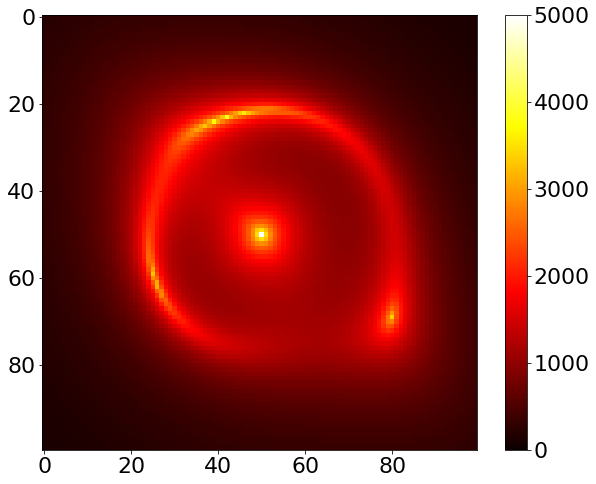

In [47]:
orig_cmap = cms.hot
print(zds[20])
f, axes = plt.subplots(1, 1, figsize=(10, 8), sharex=False, sharey=False)
pos = axes.imshow(imagesz[20][8], cmap=orig_cmap, interpolation='nearest',vmin=0.,vmax=5000.)

# add the colorbar using the figure's method,
# telling which mappable we're talking about and
# which axes object it should be near
f.colorbar(pos, ax=axes)
plt.show()

0.41000000000000003


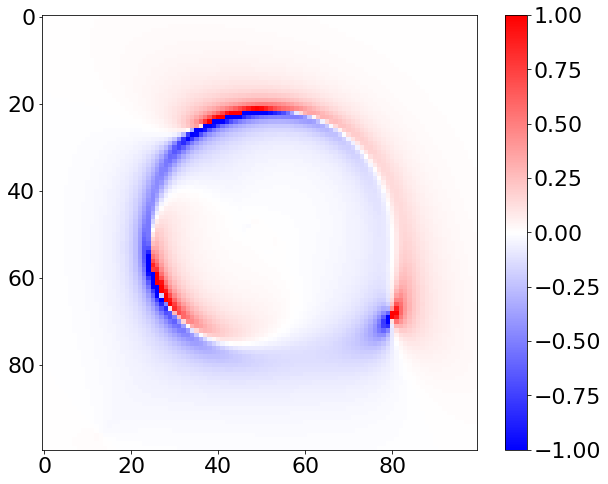

In [50]:
orig_cmap = cms.bwr
print(zds[20])
f, axes = plt.subplots(1, 1, figsize=(10, 8), sharex=False, sharey=False)
pos = axes.imshow(diff[20][10], cmap=orig_cmap, interpolation='nearest',vmin=-1.,vmax=1.)

# add the colorbar using the figure's method,
# telling which mappable we're talking about and
# which axes object it should be near
f.colorbar(pos, ax=axes)
plt.show()

In [95]:
minbin = 0.
maxbin = 2000.
numbin = 400
his0,bin0,_ = pixhist(imagesz[0][10],minbin,maxbin,numbin)
hiss,bins,_ = pixhist(imagesz[10][10],minbin,maxbin,numbin)
print(zds[10])

0.21000000000000002


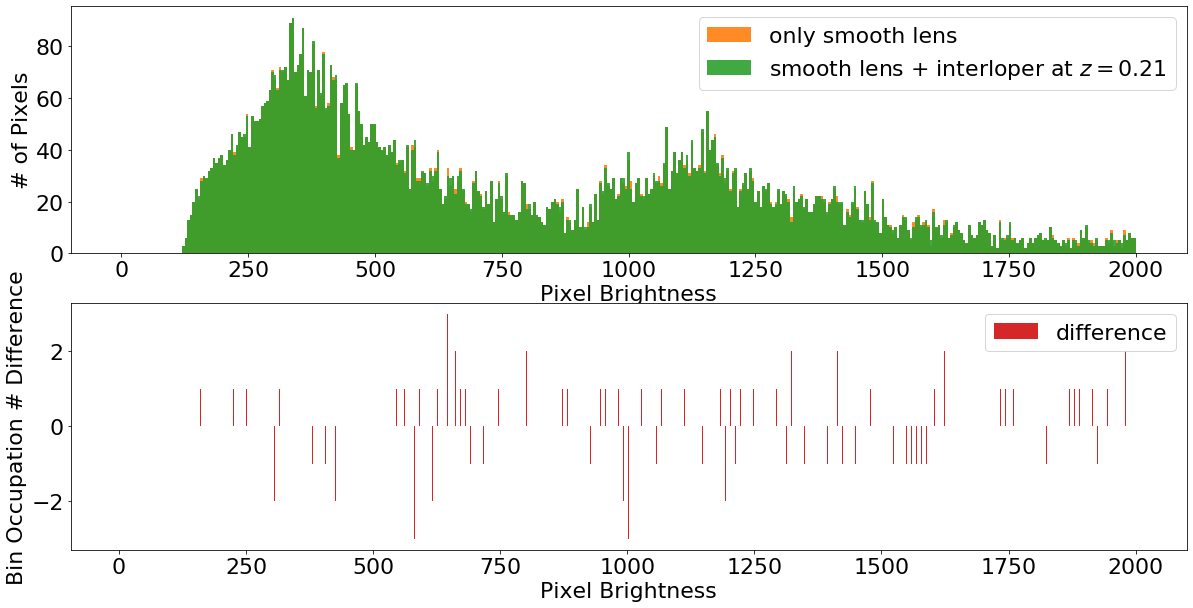

In [100]:
f, axes = plt.subplots(2, 1, figsize=(20, 10), sharex=False, sharey=False)
bins = np.linspace(minbin,maxbin,numbin)
h1 = axes[0].hist(np.ndarray.flatten(imagesz[0][10]),bins,alpha=0.9,color='C1',label='only smooth lens')
h2 = axes[0].hist(np.ndarray.flatten(imagesz[10][10]),bins,alpha=0.9,color='C2',label='smooth lens + interloper at $z=0.21$')
axes[1].bar(bins[1:],h1[0]-h2[0],color='C3',label='difference')


axes[0].set_xlabel('Pixel Brightness')
axes[0].set_ylabel('# of Pixels')
axes[1].set_xlabel('Pixel Brightness')
axes[1].set_ylabel('Bin Occupation # Difference')
axes[0].legend()
axes[1].legend()
plt.show()

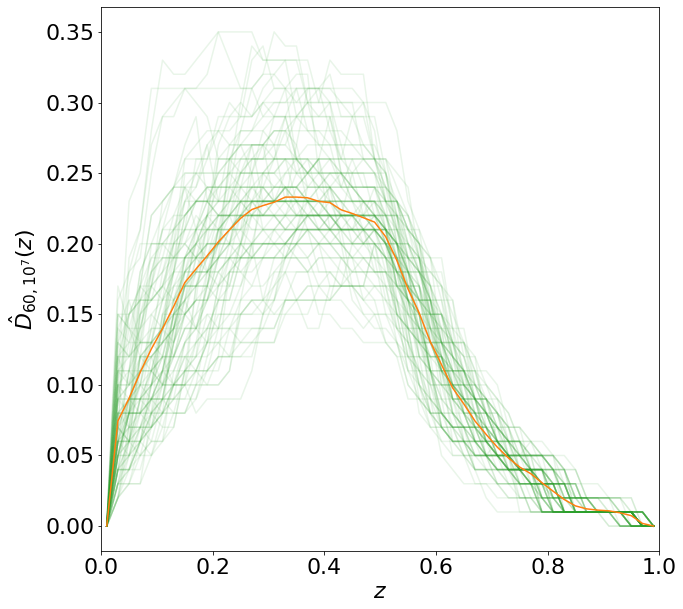

In [105]:
f, axes = plt.subplots(1, 1, figsize=(10, 10), sharex=False, sharey=False)

plt.plot(zds,hisssqr, 'C2-',alpha=0.1,label='redshift dependence')
plt.plot(zds,hissmean , 'C1-',label='redshift dependence')

plt.xlabel('$z$')
plt.ylabel('$\hat{D}_{60,10^7}(z)$')
plt.xlim(0,1)
#plt.xscale('log')
#plt.yscale('log')
#plt.legend()
plt.show()

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


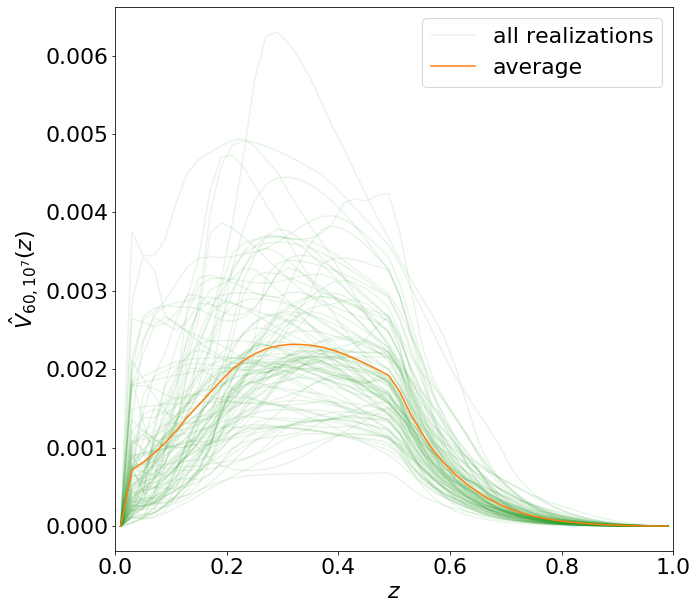

In [15]:
sample = np.zeros(50)
for i in range(50):
    sample[i] = sqrmean[i][0]
    
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

mpl.rc('font', **font)    
f, axes = plt.subplots(1, 1, figsize=(10, 10), sharex=False, sharey=False)

plt.plot(zds,sample , 'C2-',alpha=0.1,label='all realizations')
plt.plot(zds,sqrmean , 'C2-',alpha=0.1)
plt.plot(zds,sqrmeanmean , 'C1-',label='average')

plt.xlabel('$z$')
plt.ylabel('$\hat{V}_{60,10^7}(z)$')
plt.xlim(0,1)
#plt.xscale('log')
#plt.yscale('log')
plt.legend()
plt.show()

0.01


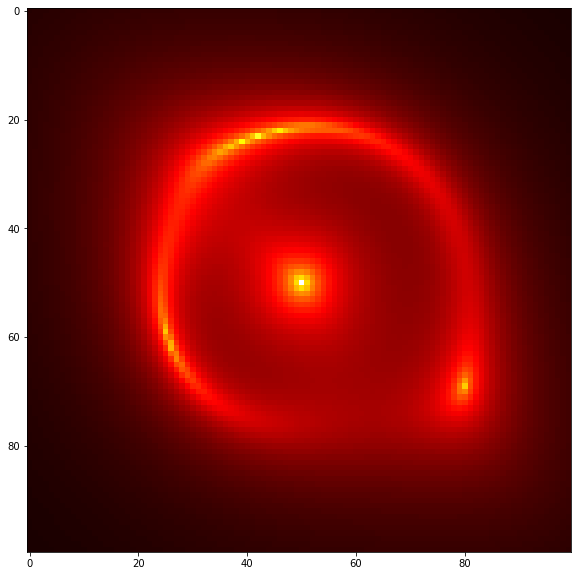

0.03


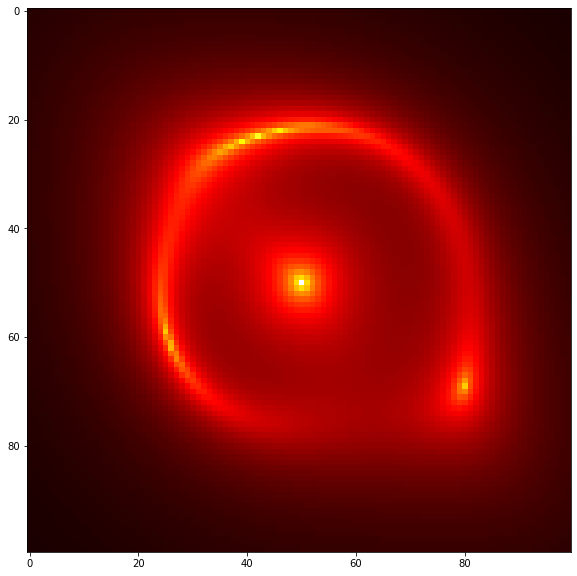

0.05


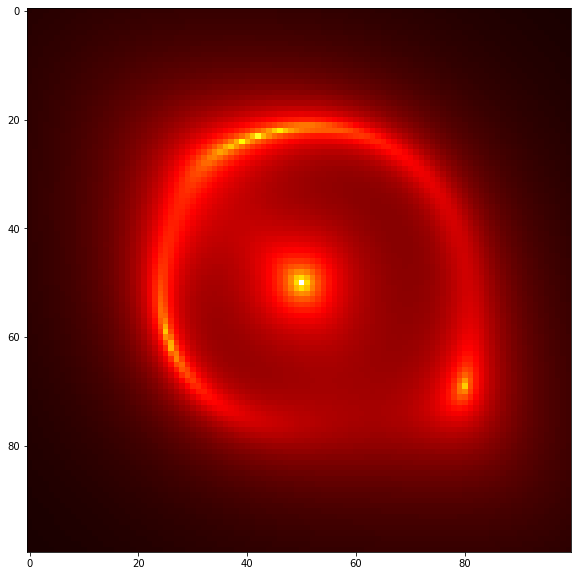

0.06999999999999999


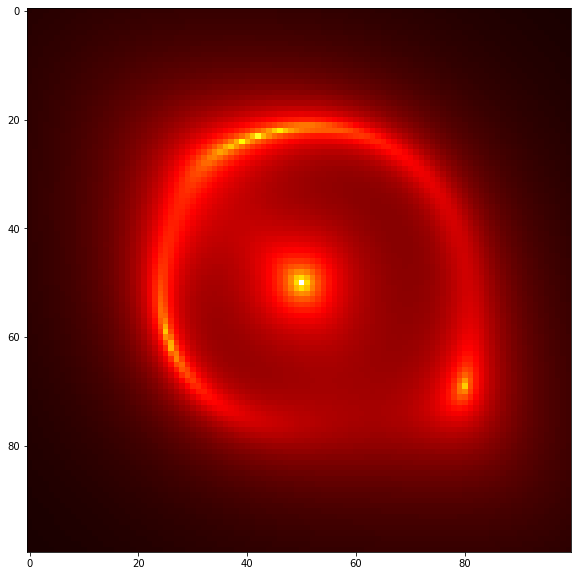

0.09


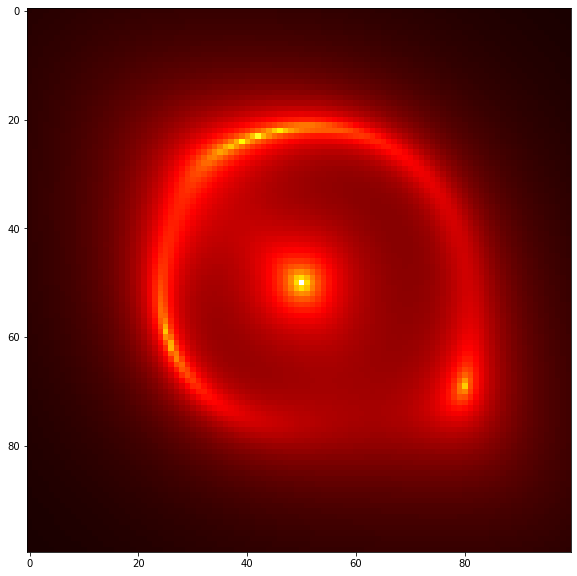

0.11


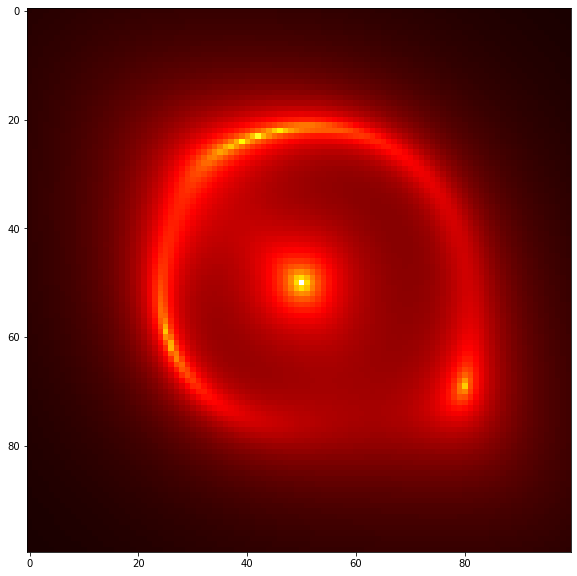

0.13


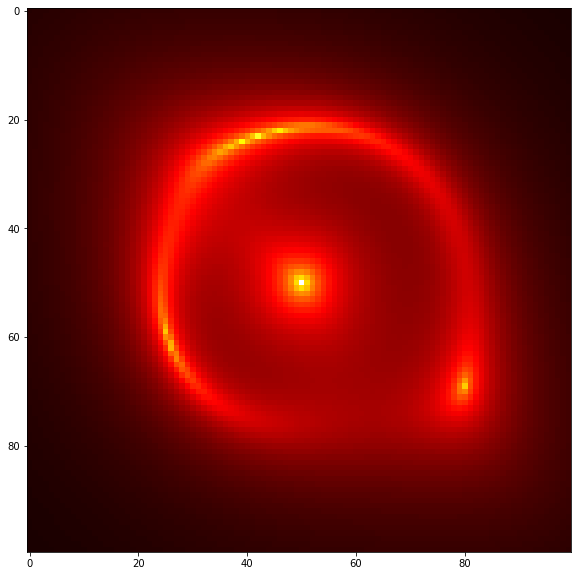

0.15000000000000002


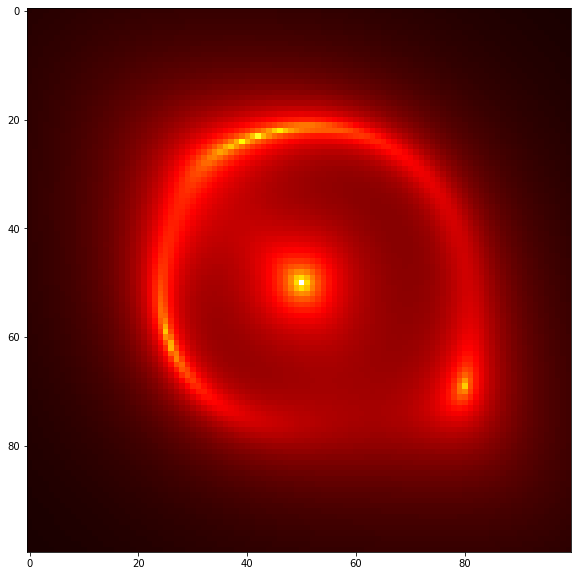

0.17


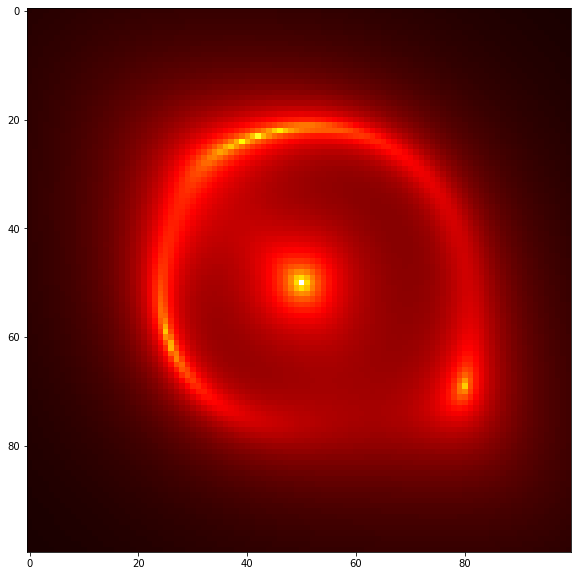

0.19


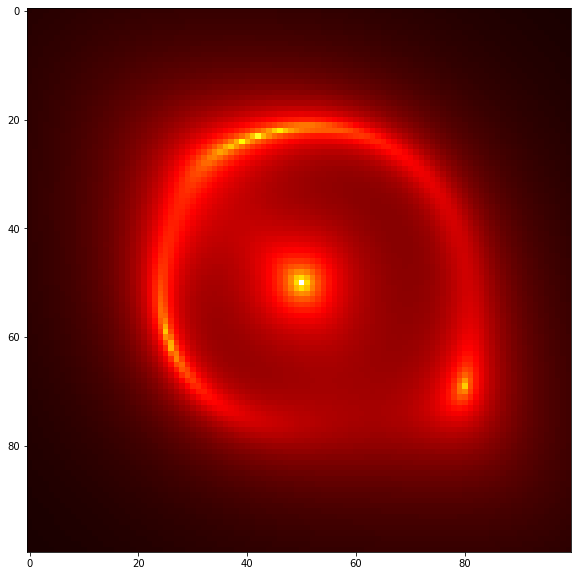

0.21000000000000002


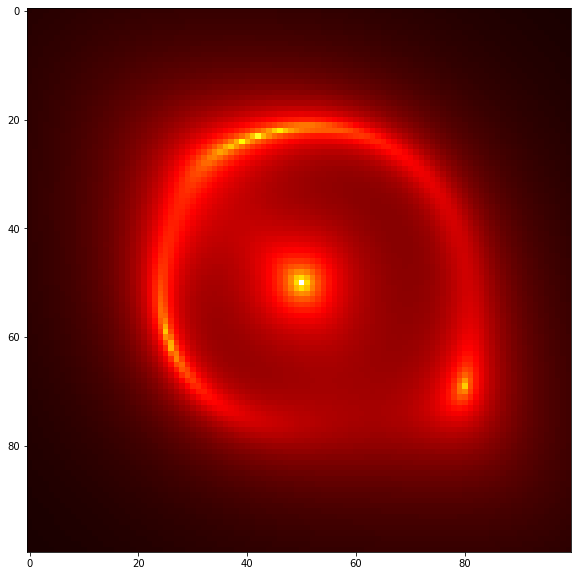

0.23


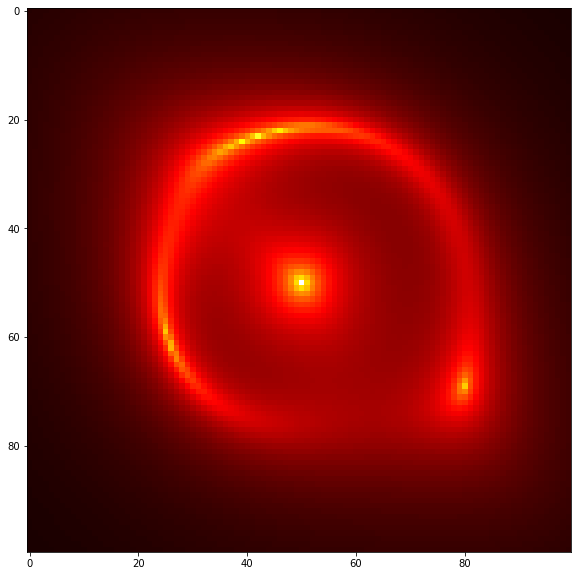

0.25


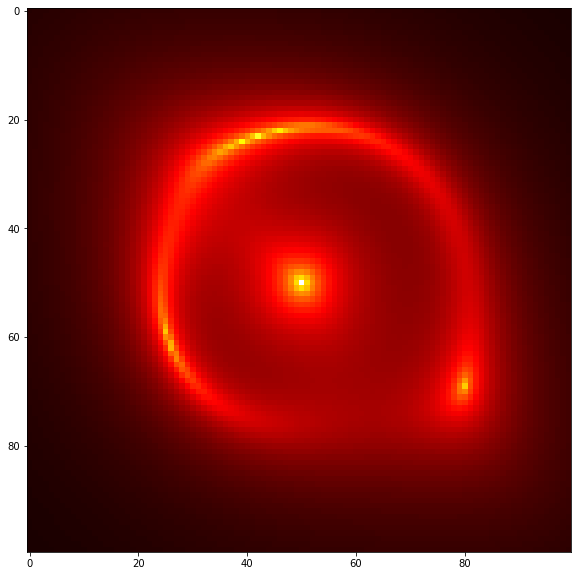

0.27


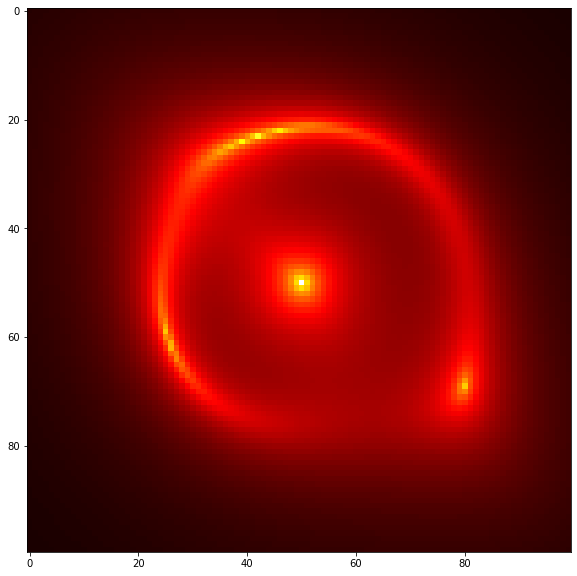

0.29000000000000004


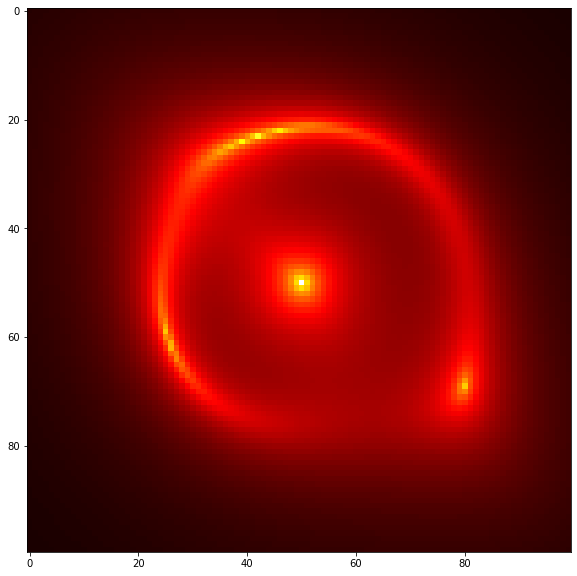

0.31


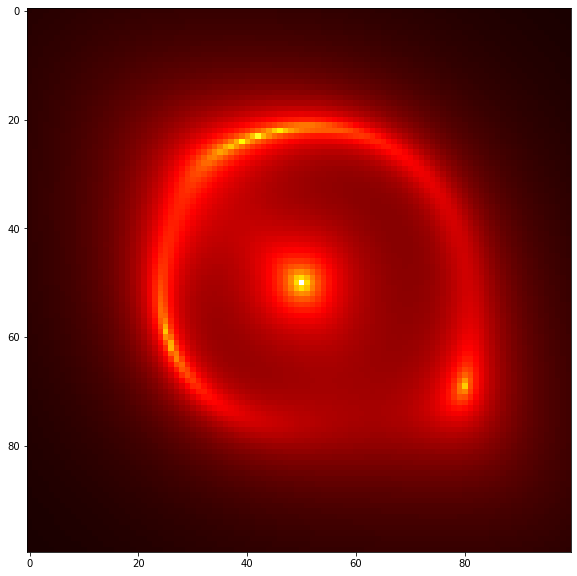

0.33


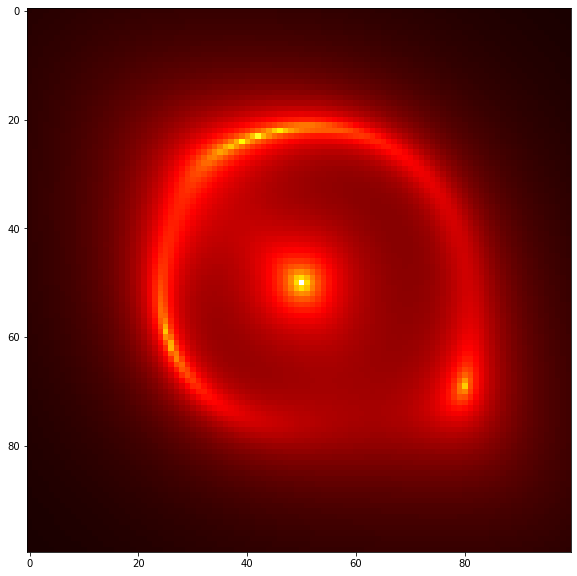

0.35000000000000003


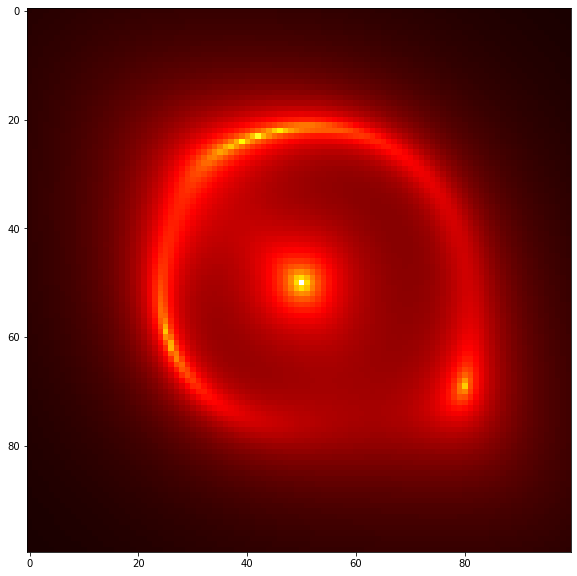

0.37


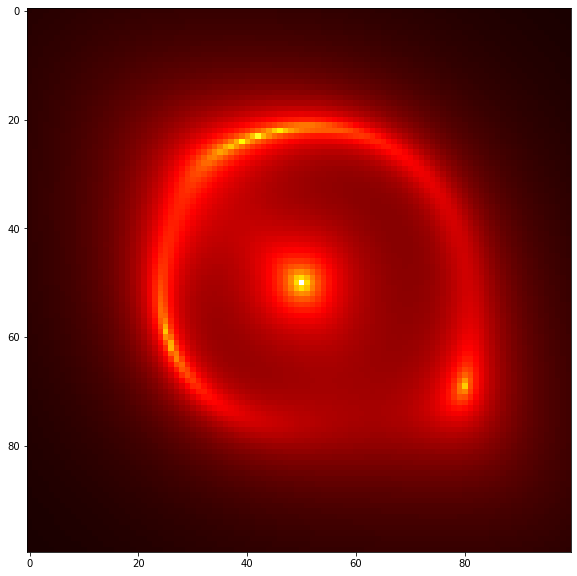

0.39


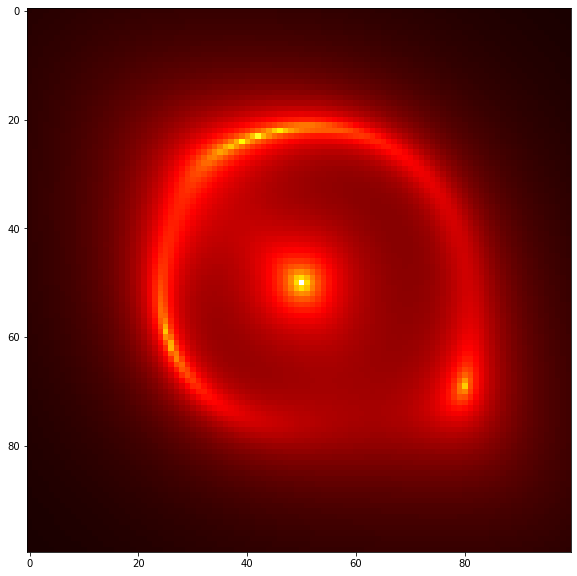

0.41000000000000003


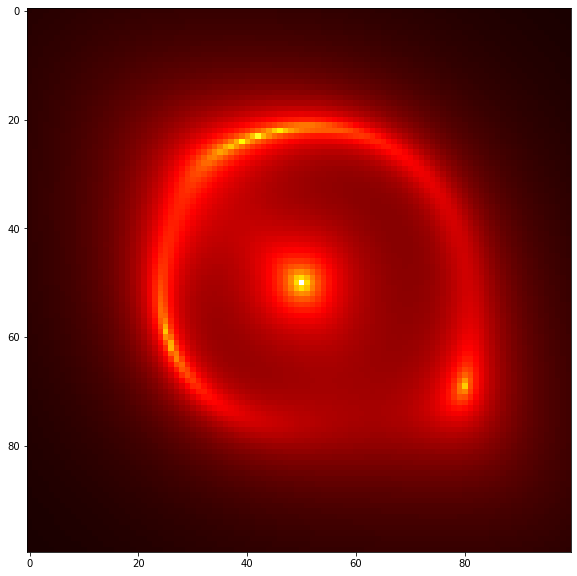

0.43


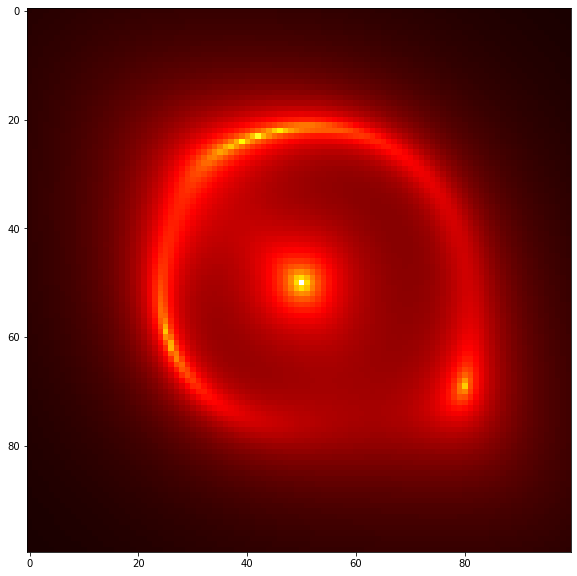

0.45


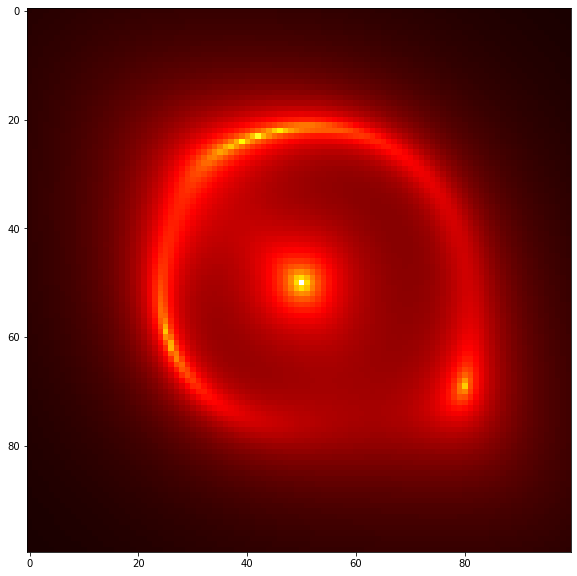

0.47000000000000003


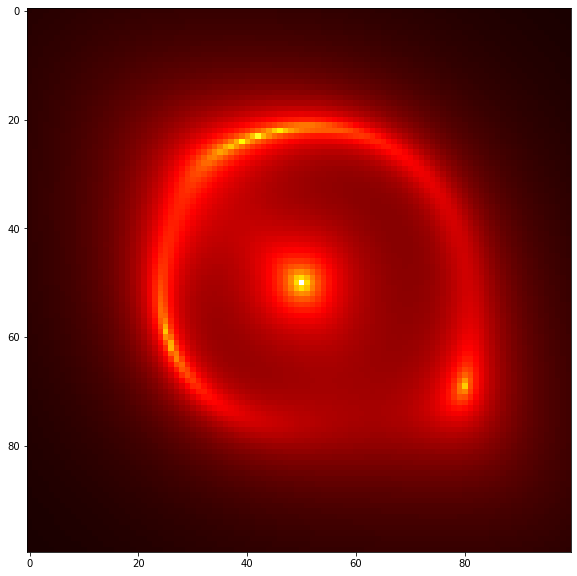

0.49


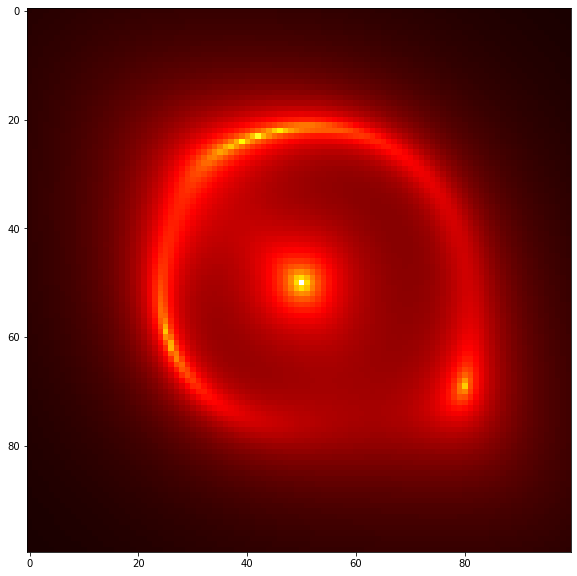

0.51


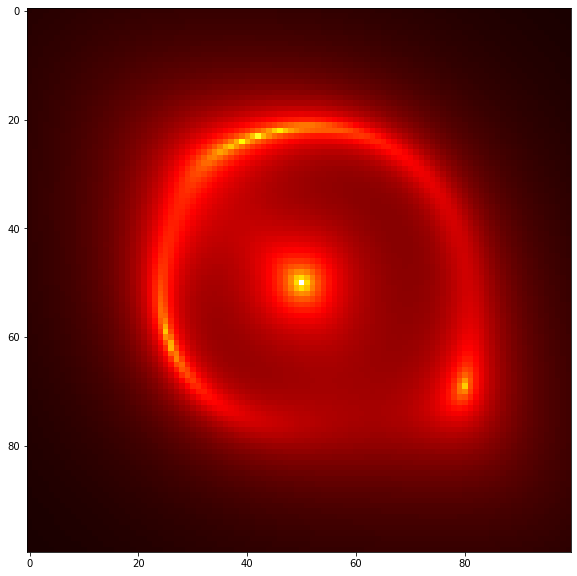

0.53


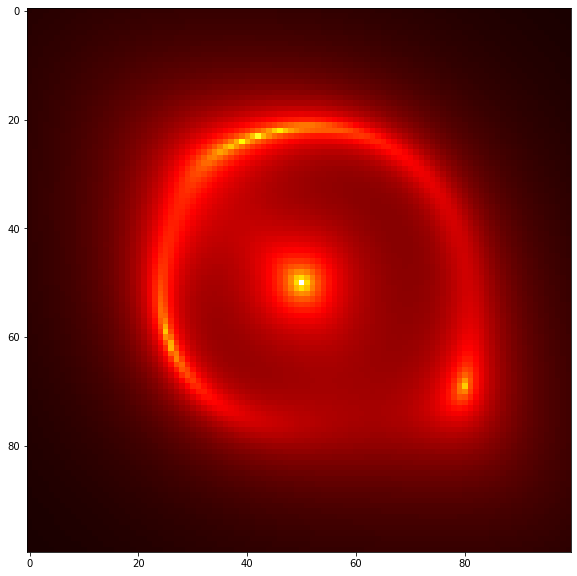

0.55


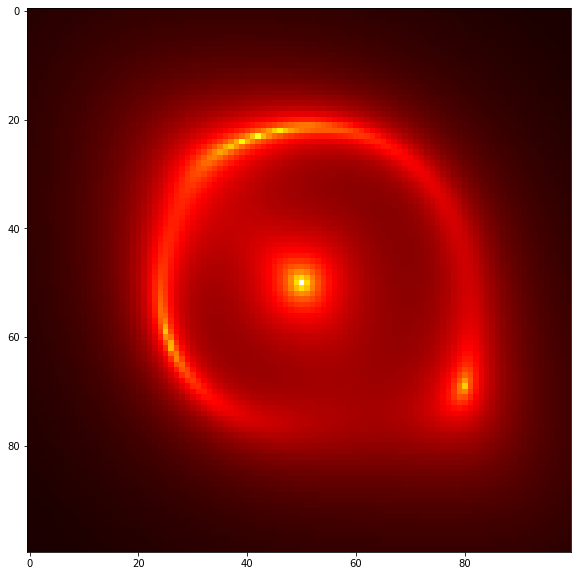

0.5700000000000001


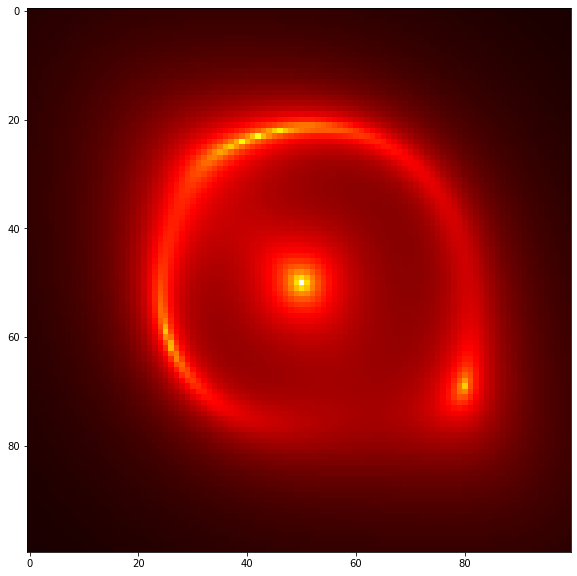

0.59


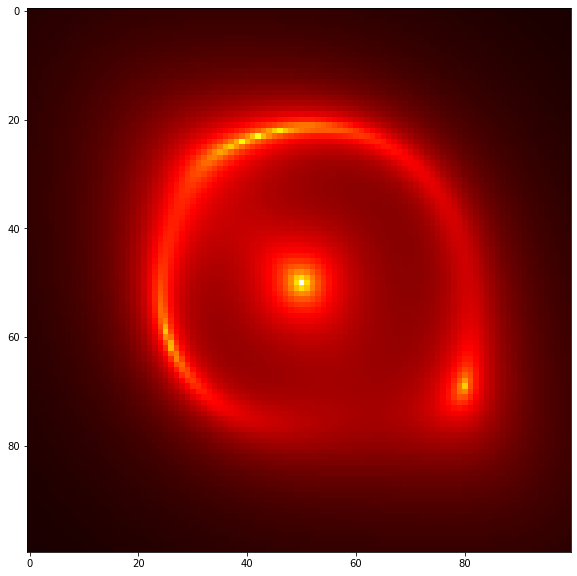

0.61


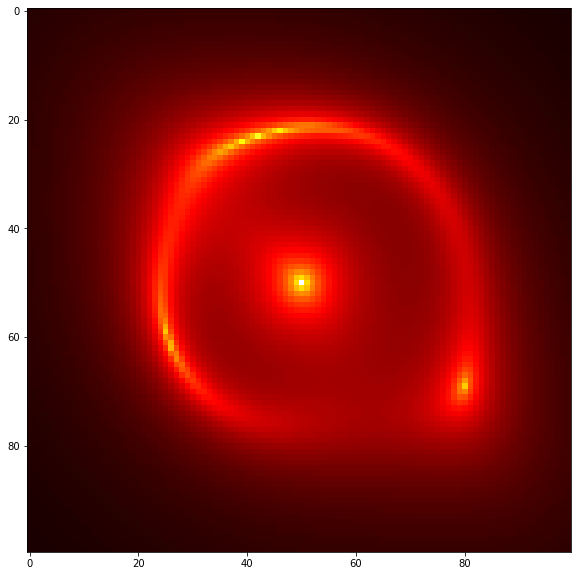

0.63


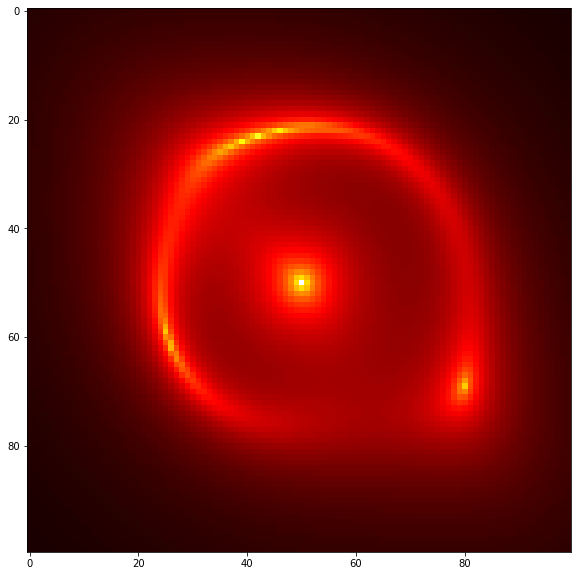

0.65


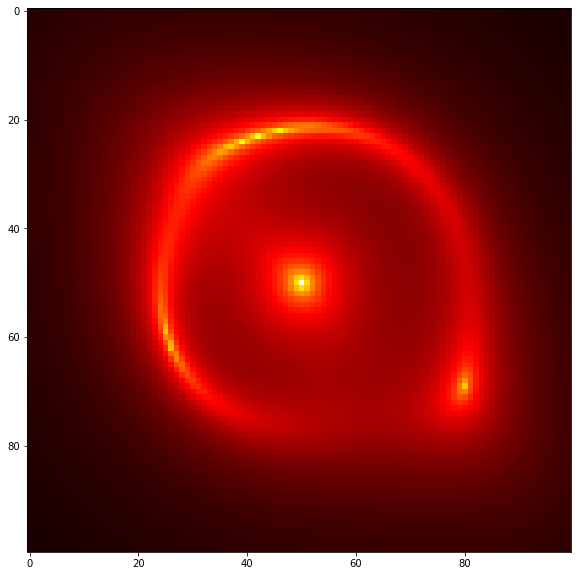

0.67


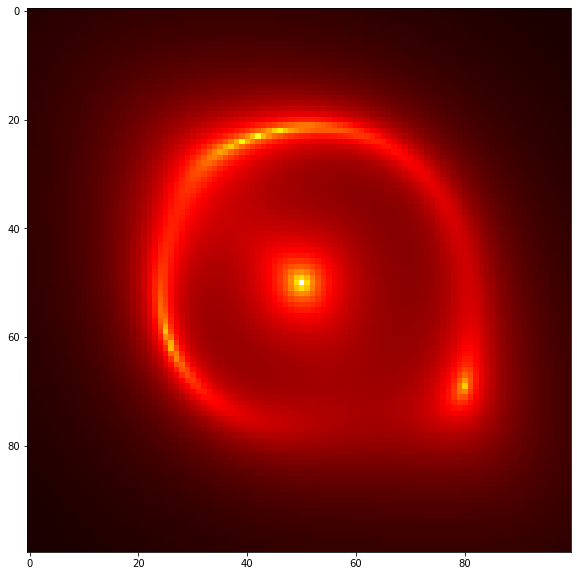

0.6900000000000001


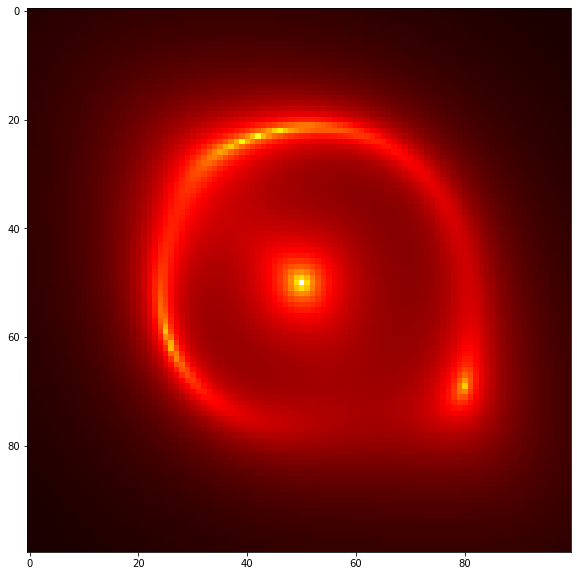

0.7100000000000001


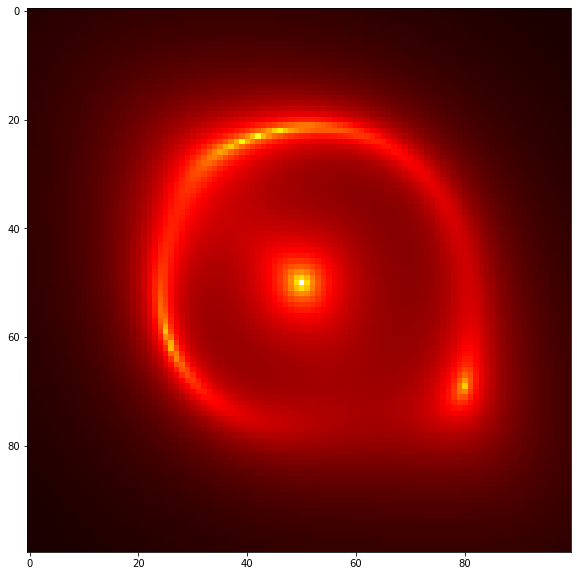

0.73


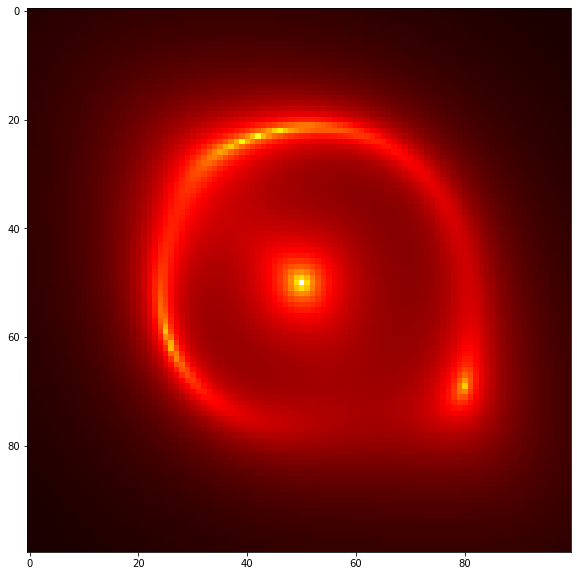

0.75


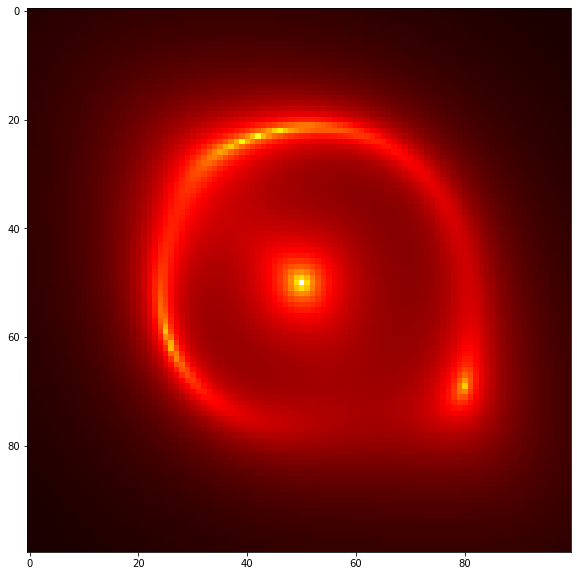

0.77


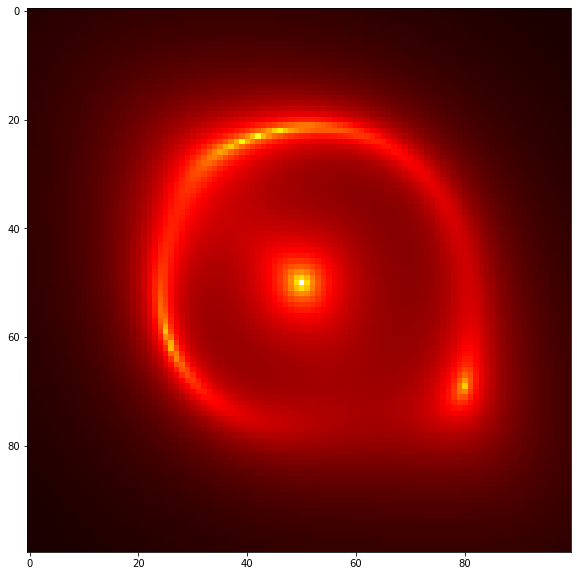

0.79


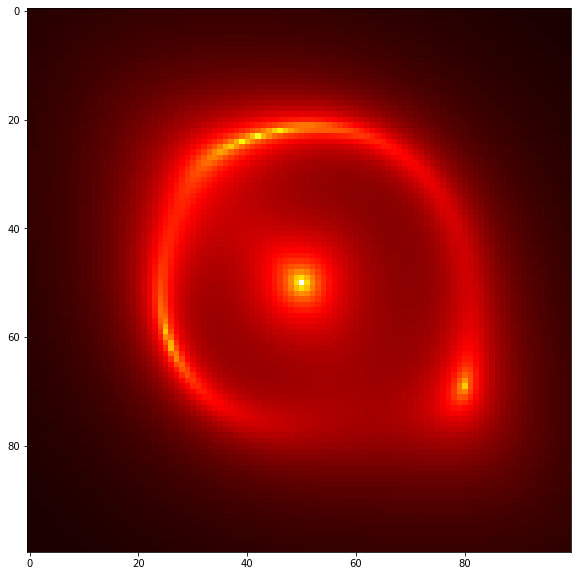

0.81


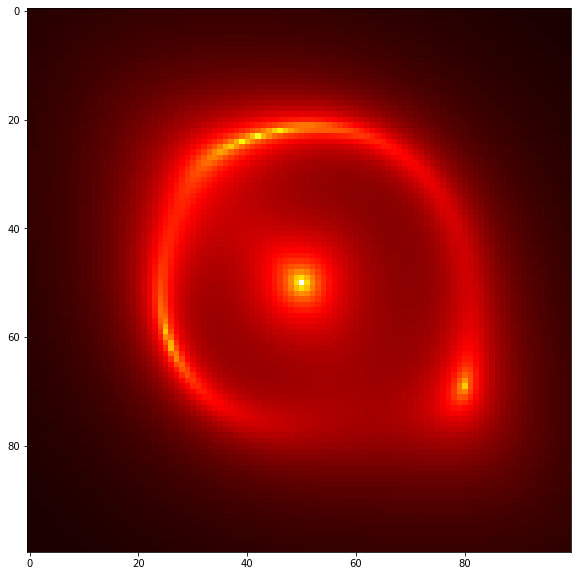

0.8300000000000001


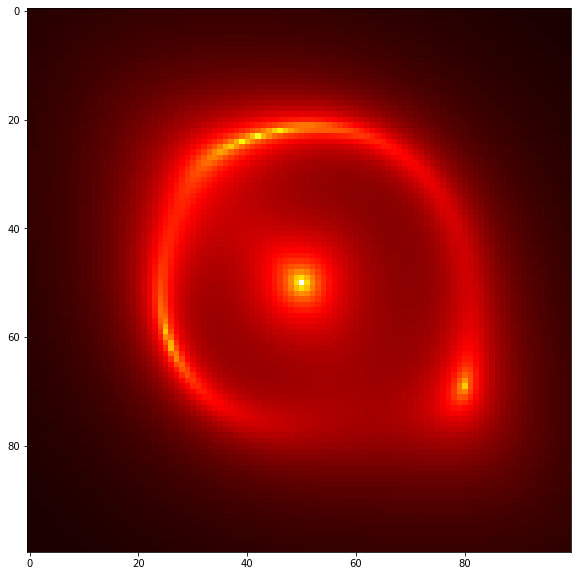

0.85


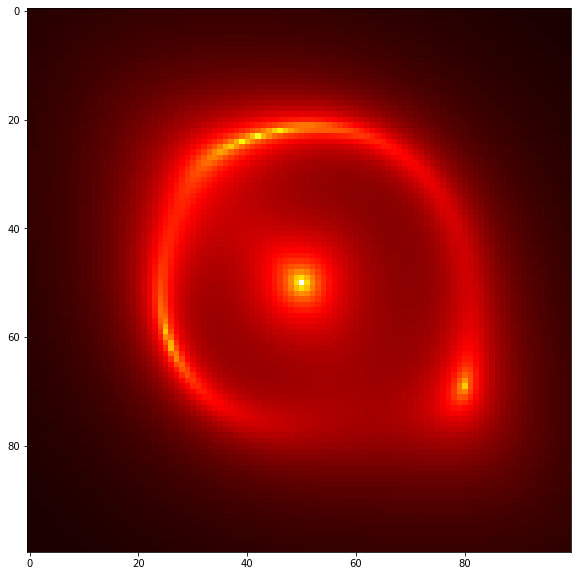

0.87


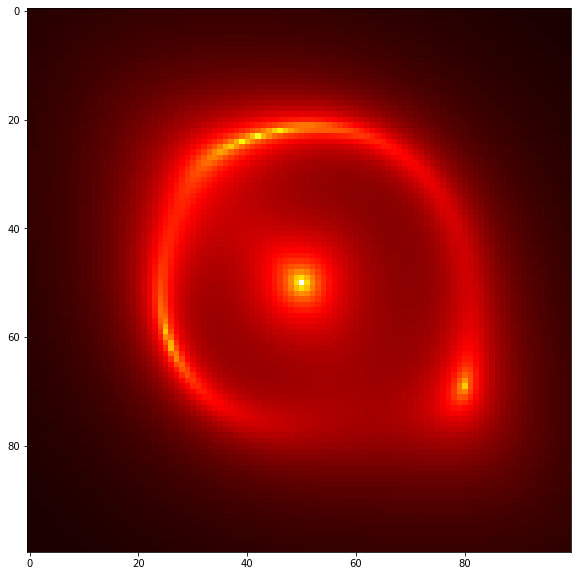

0.89


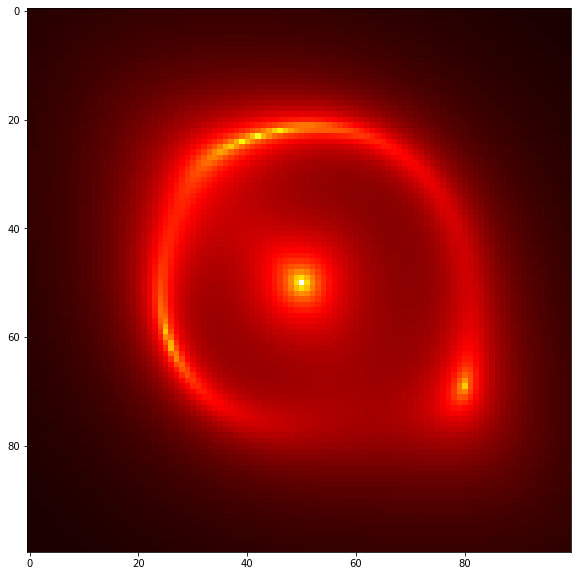

0.91


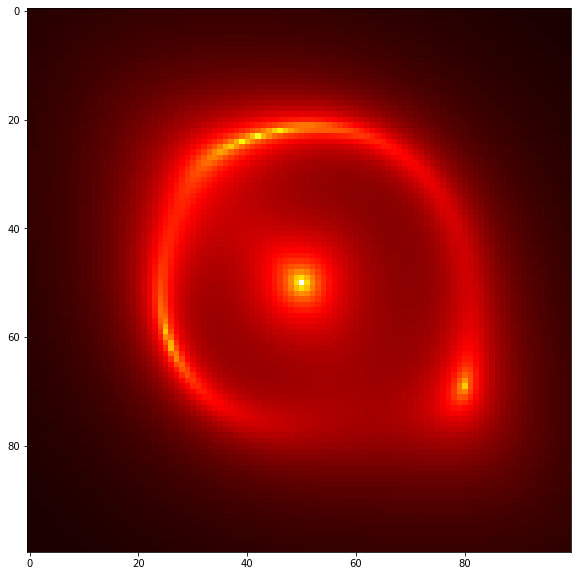

0.93


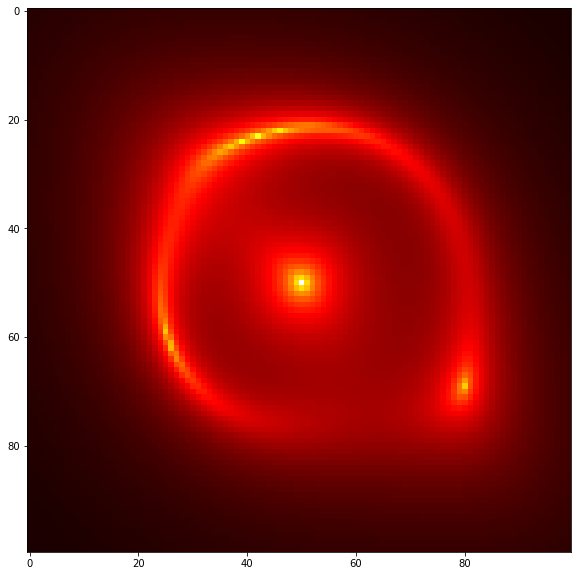

0.9500000000000001


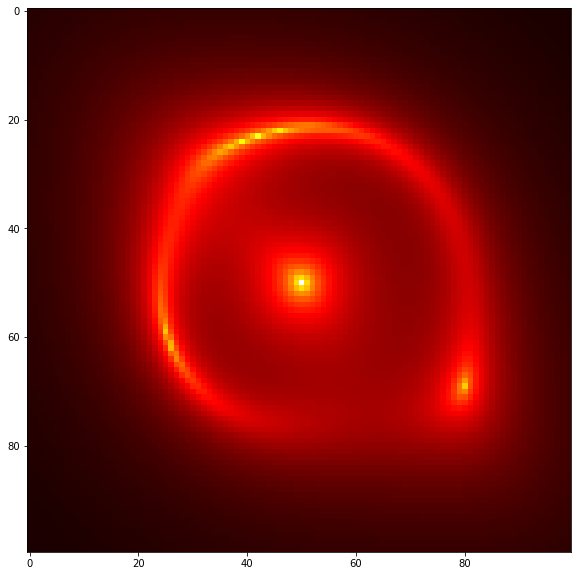

0.97


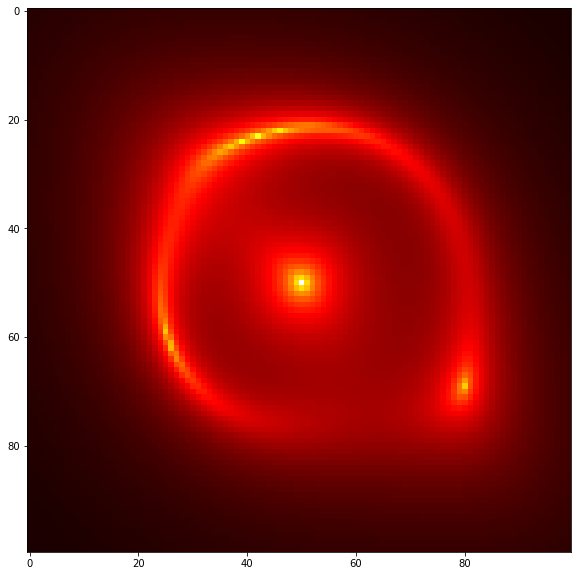

0.99


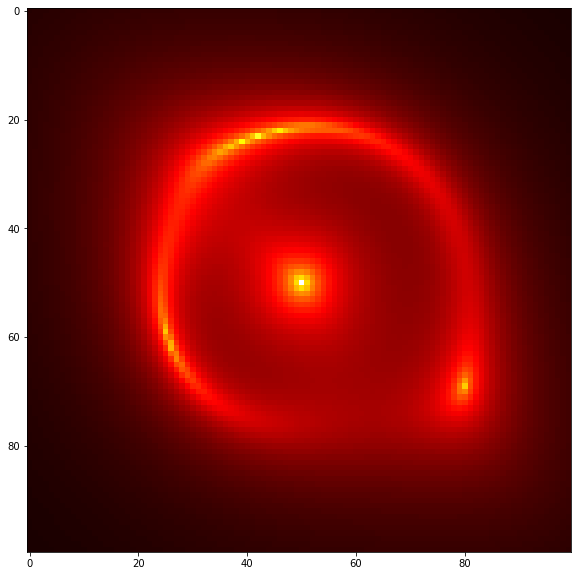

In [23]:
orig_cmap = cms.hot
for i in range(Nit):
    f, axes = plt.subplots(1, 1, figsize=(10, 10), sharex=False, sharey=False)
    axes.imshow(imagesz[i][8], cmap=orig_cmap, interpolation='nearest',vmin=0.,vmax=5000.)
    print(zds[i])
    plt.show()

0.01


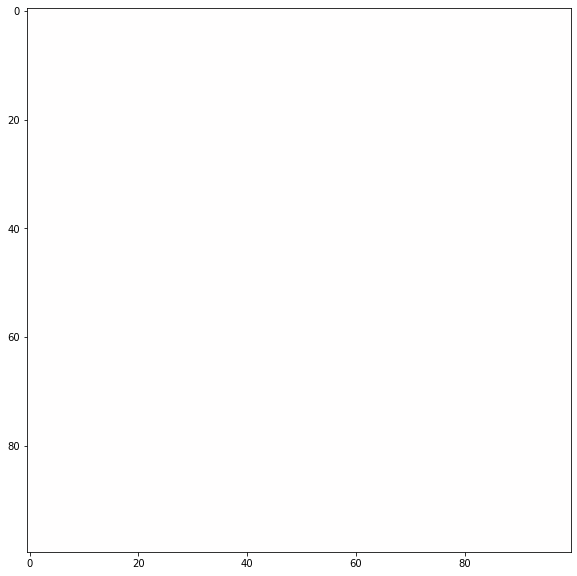

0.03


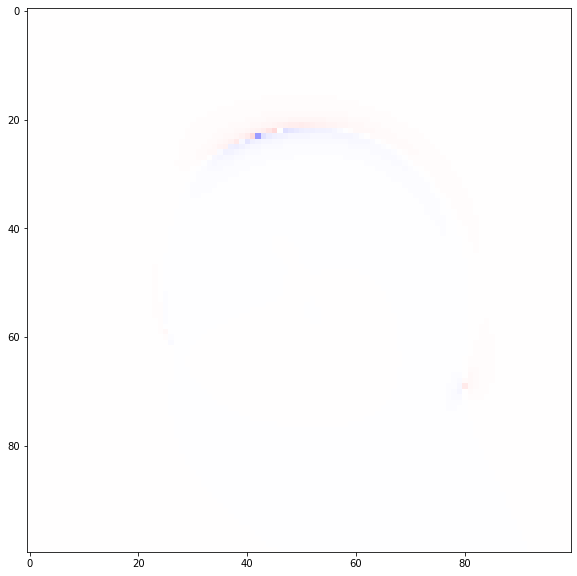

0.05


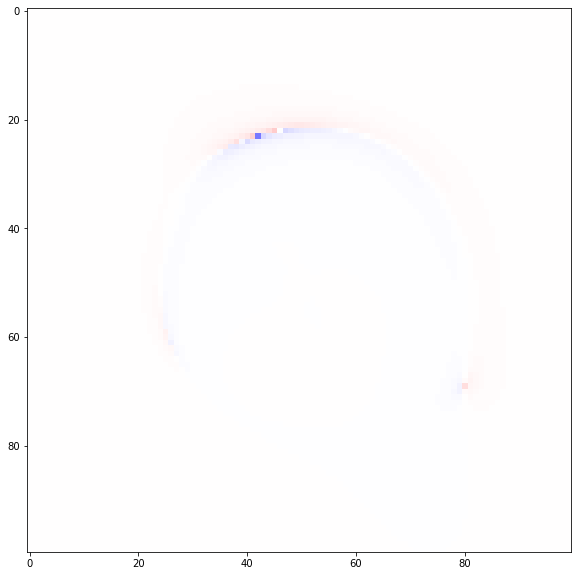

0.06999999999999999


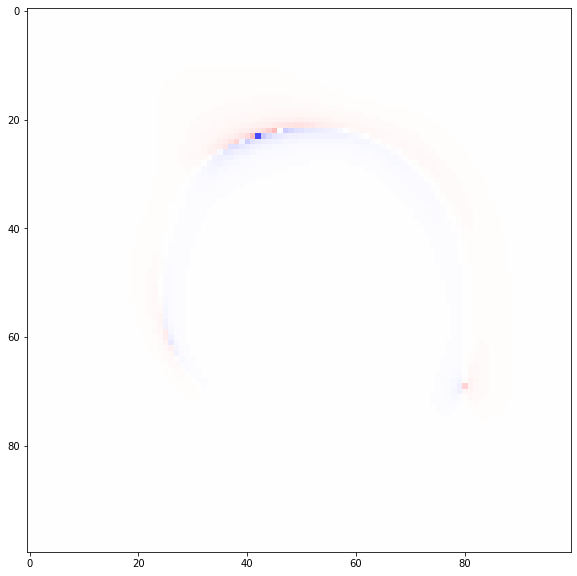

0.09


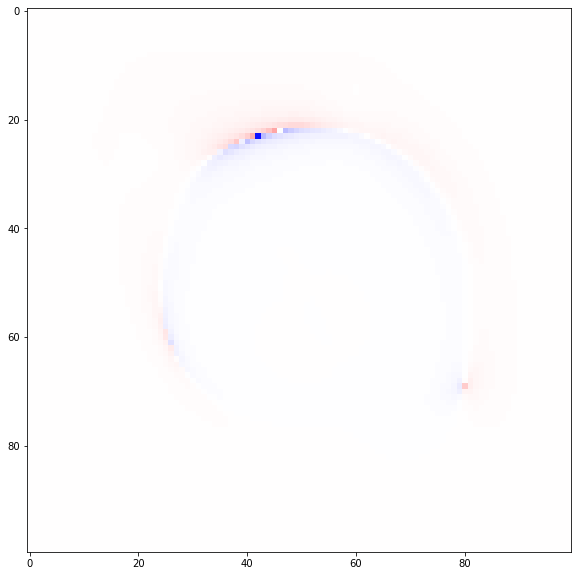

0.11


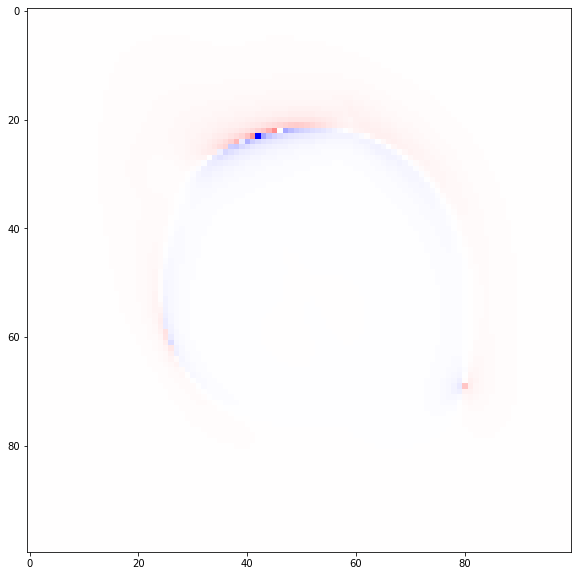

0.13


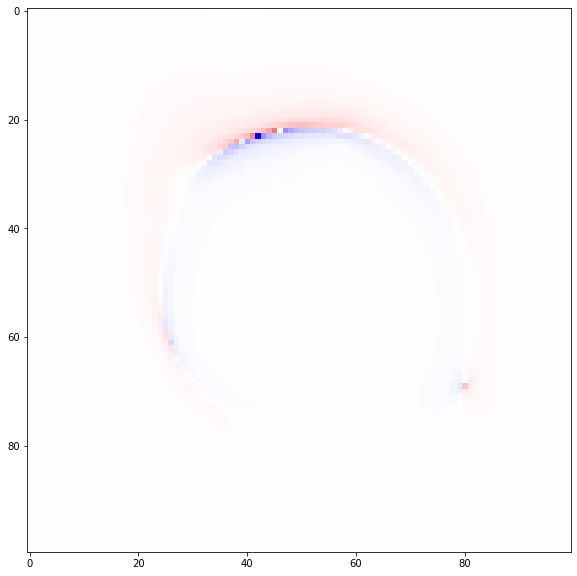

0.15000000000000002


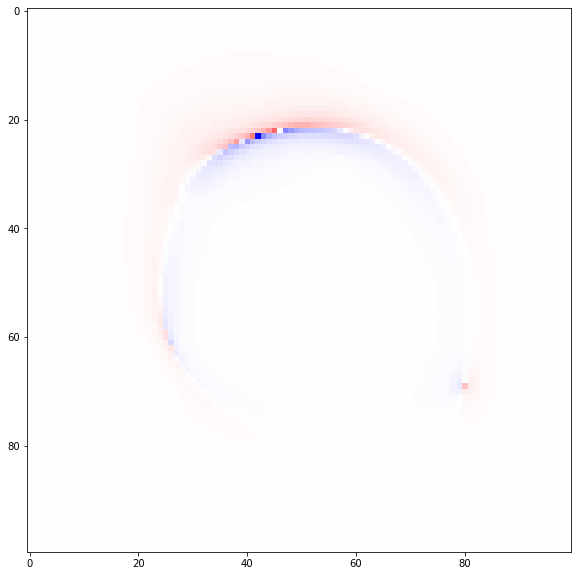

0.17


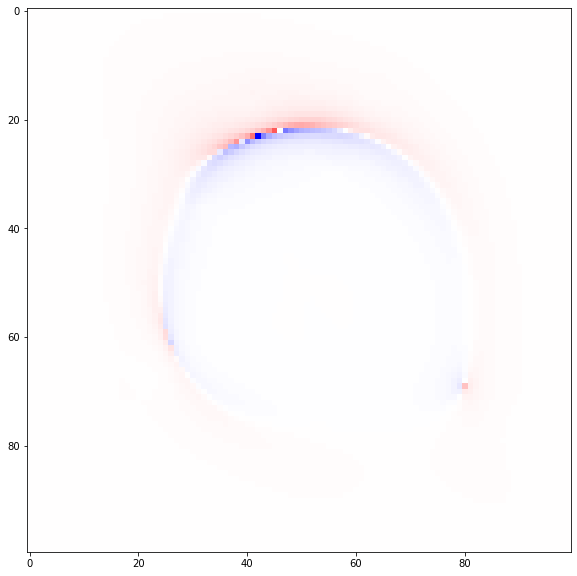

0.19


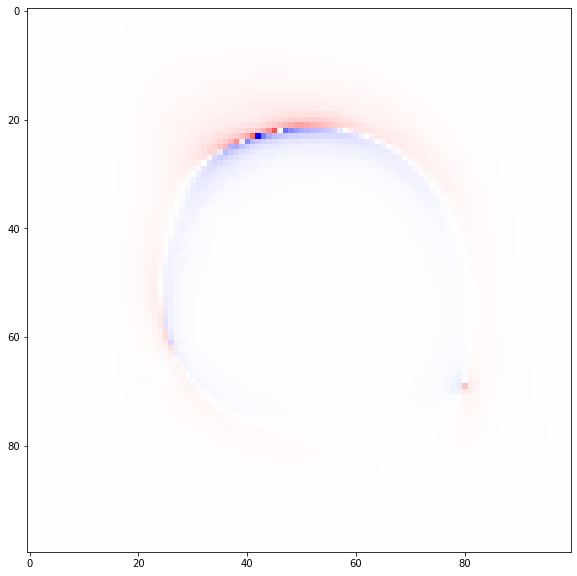

0.21000000000000002


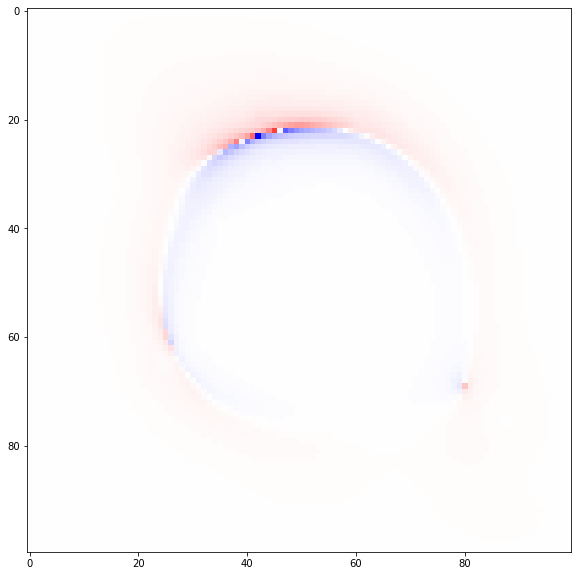

0.23


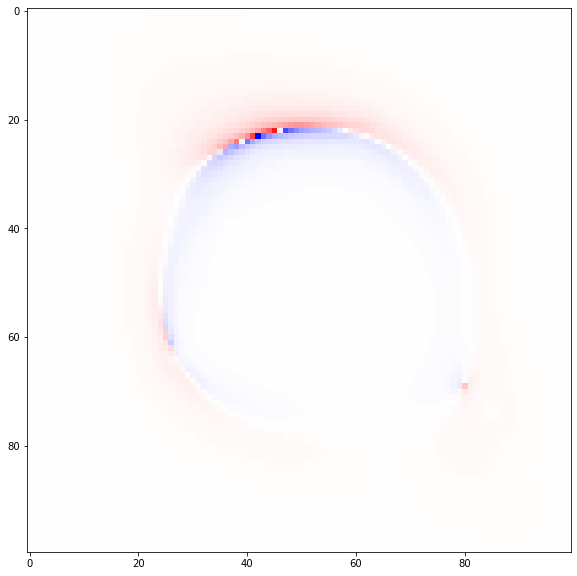

0.25


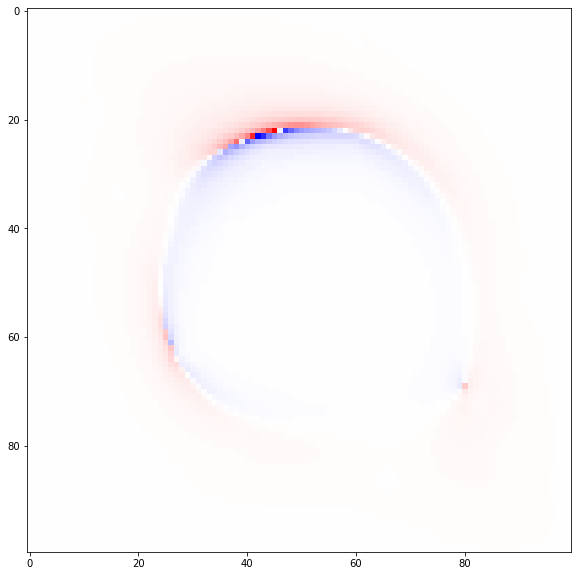

0.27


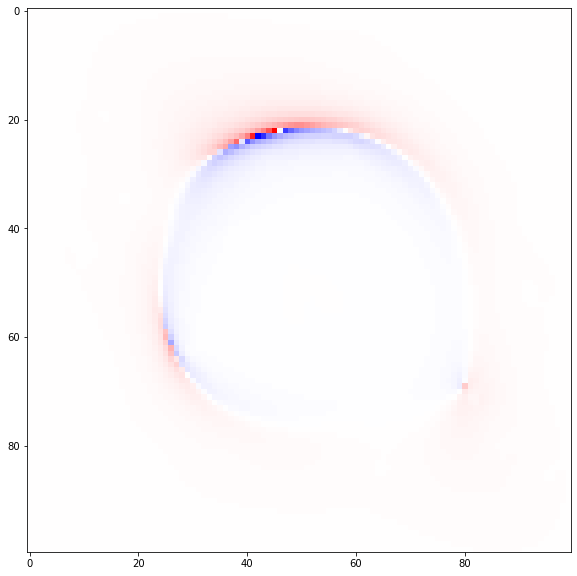

0.29000000000000004


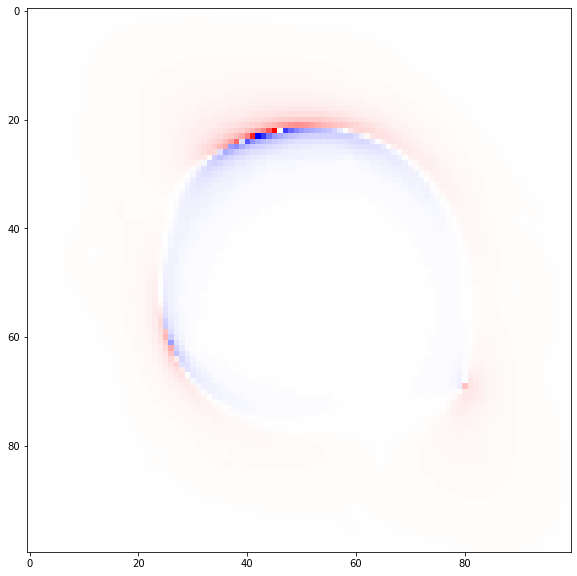

0.31


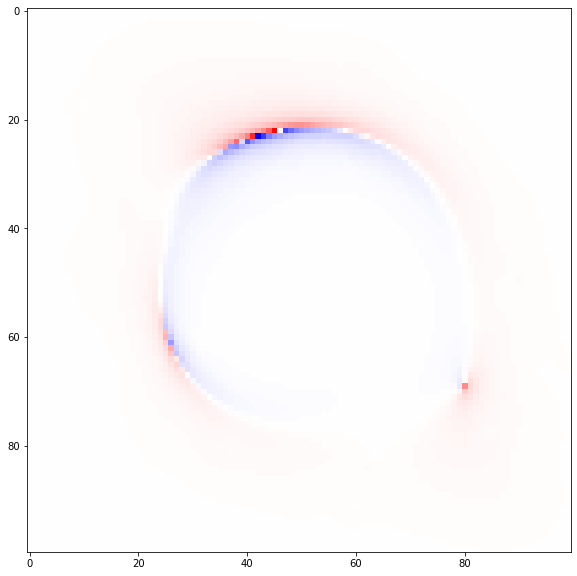

0.33


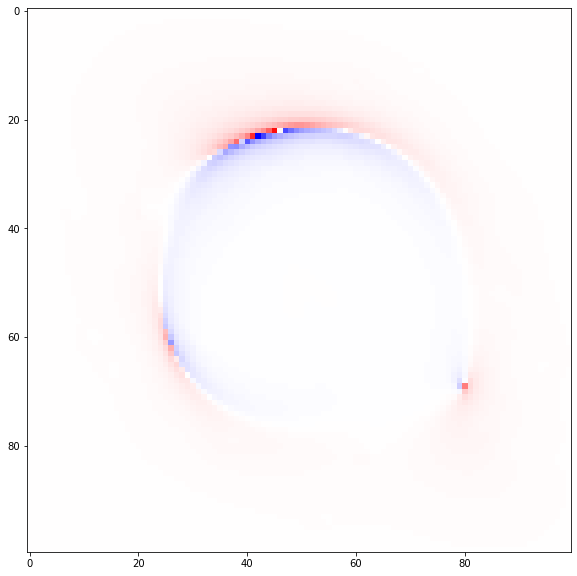

0.35000000000000003


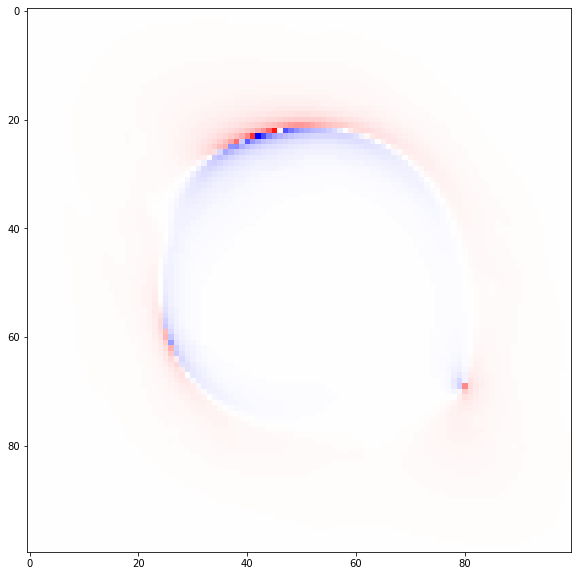

0.37


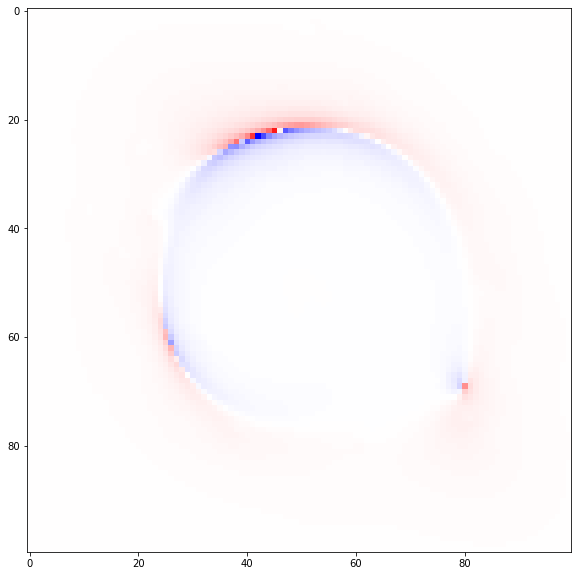

0.39


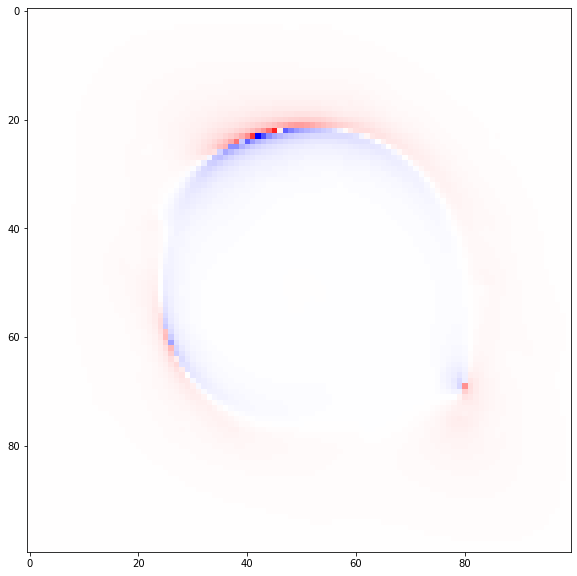

0.41000000000000003


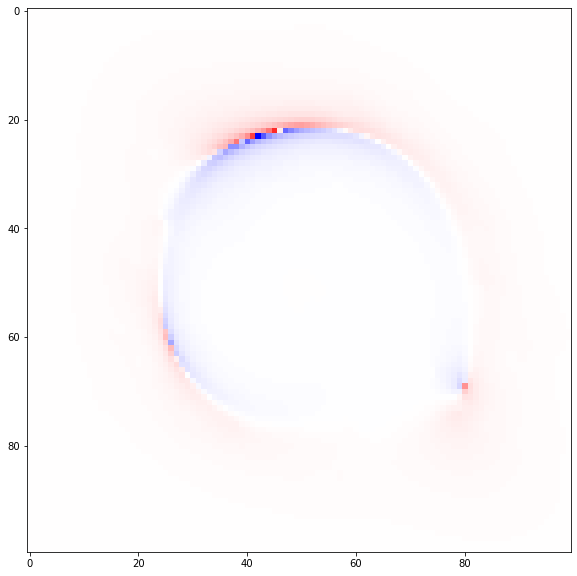

0.43


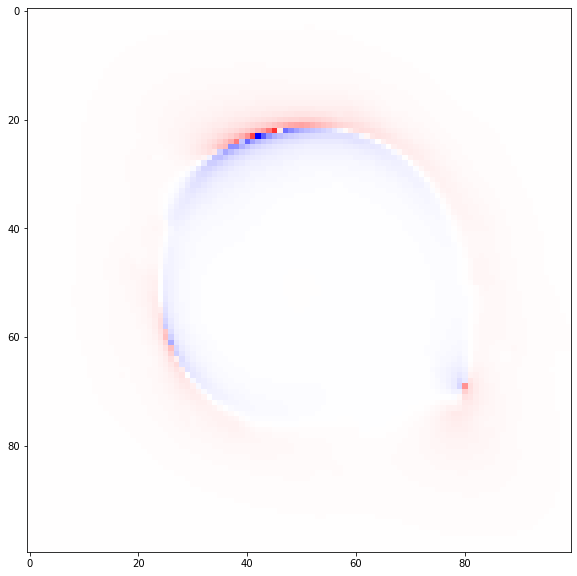

0.45


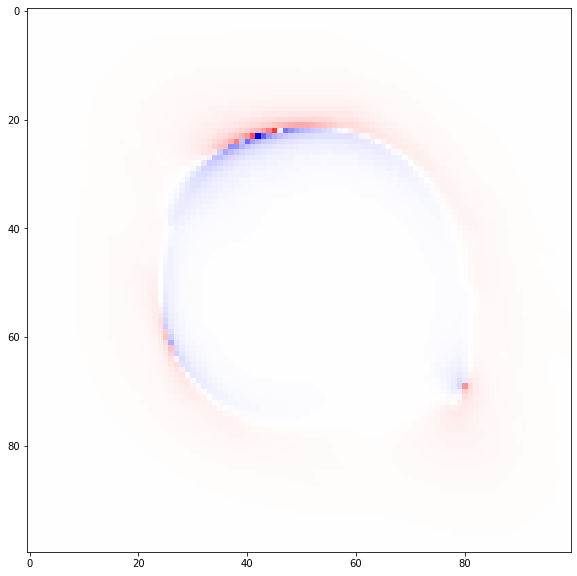

0.47000000000000003


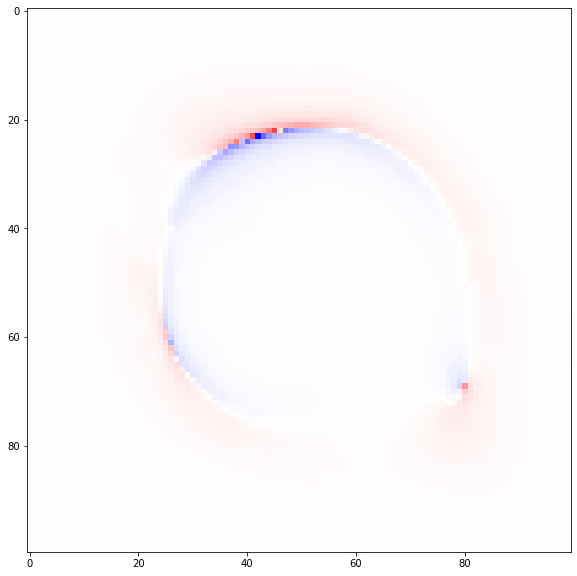

0.49


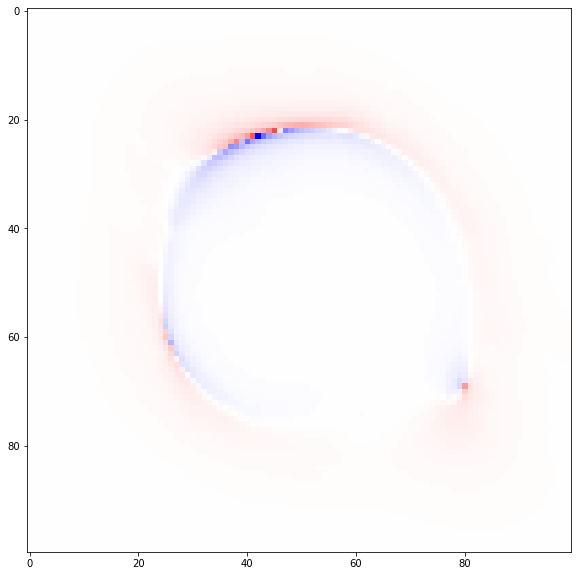

0.51


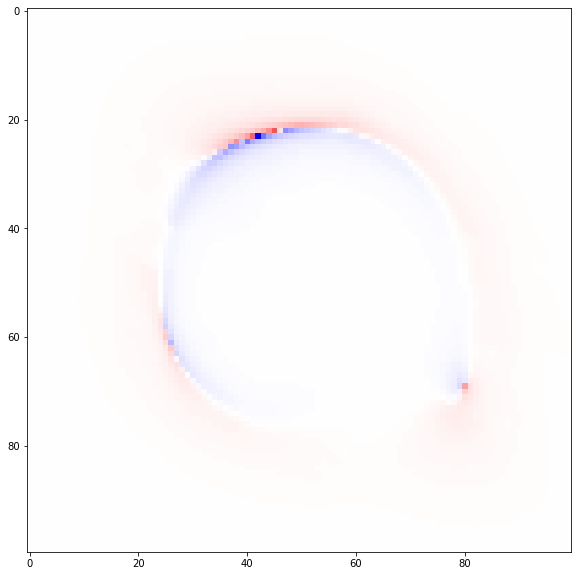

0.53


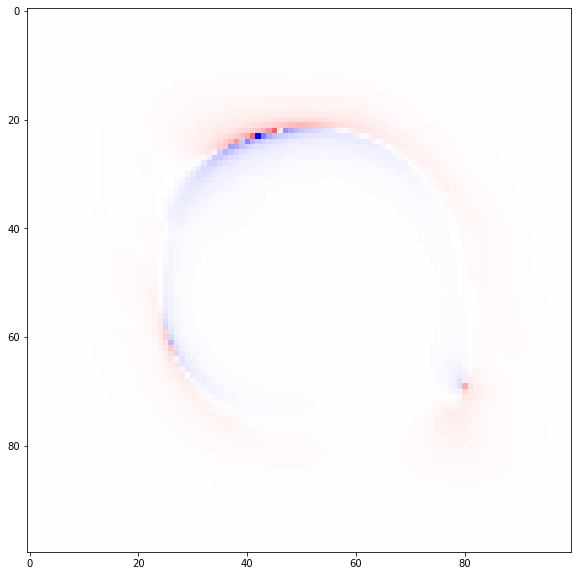

0.55


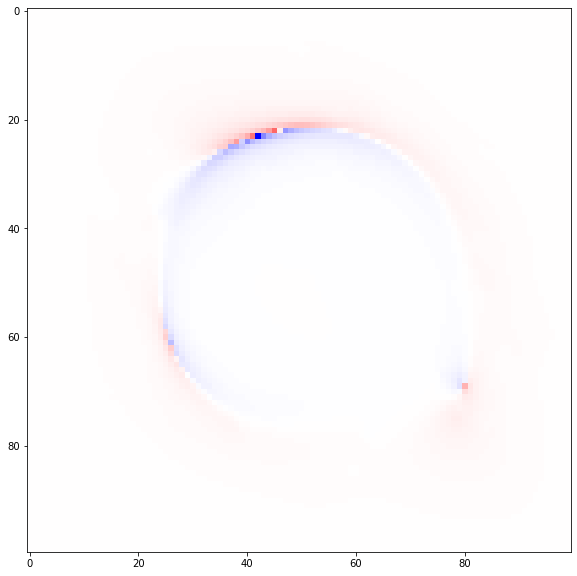

0.5700000000000001


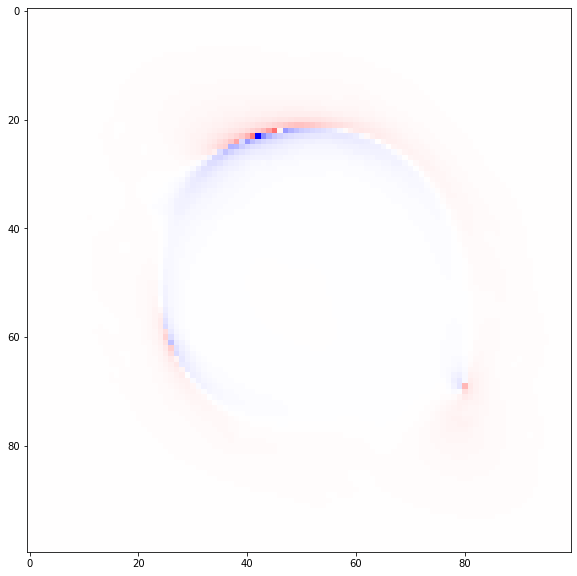

0.59


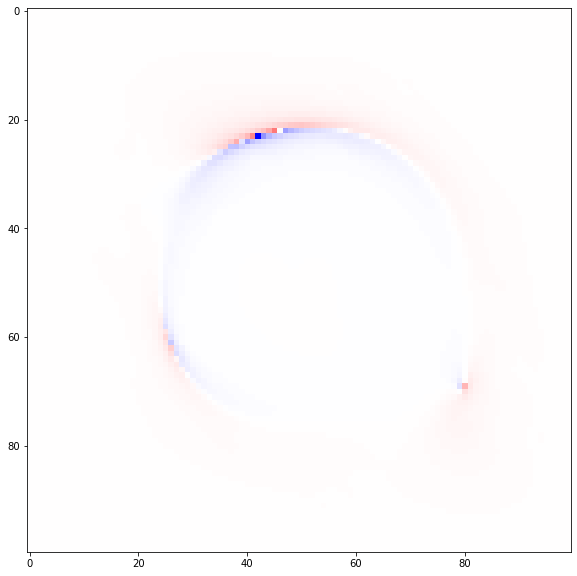

0.61


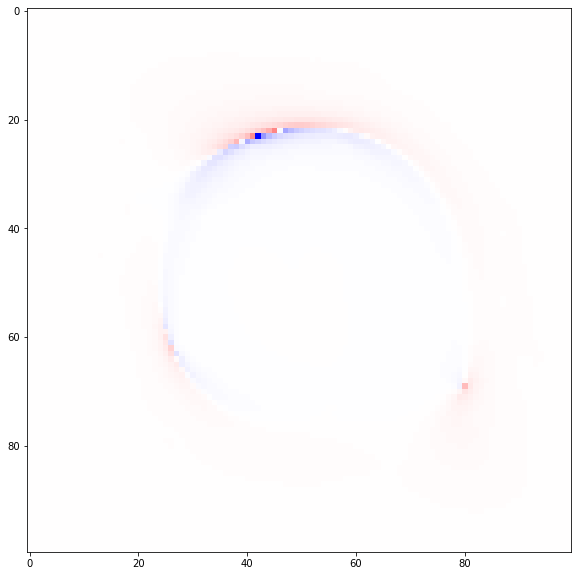

0.63


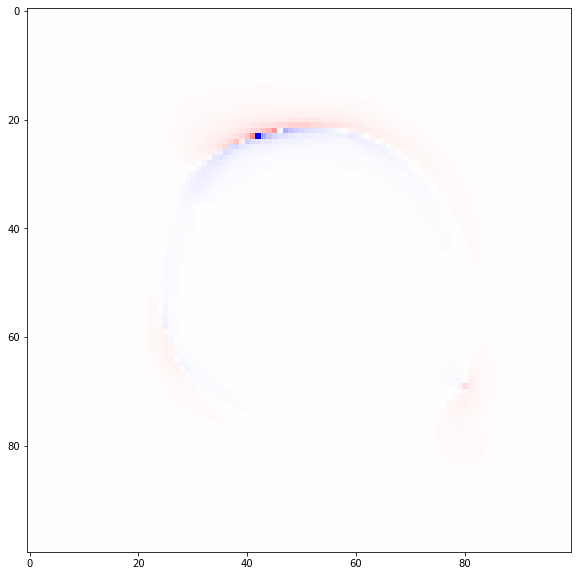

0.65


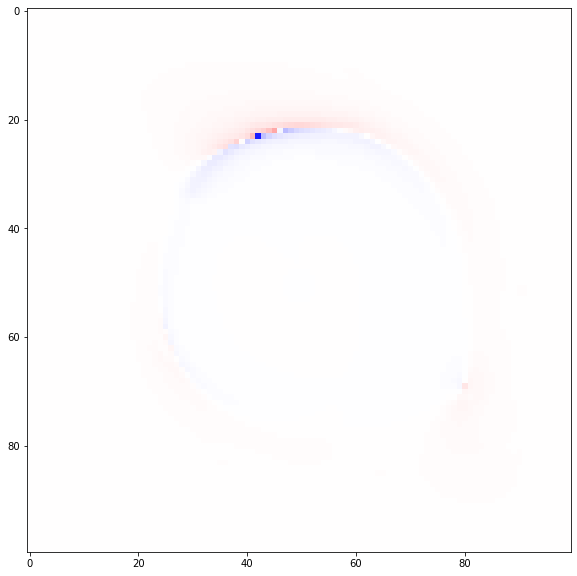

0.67


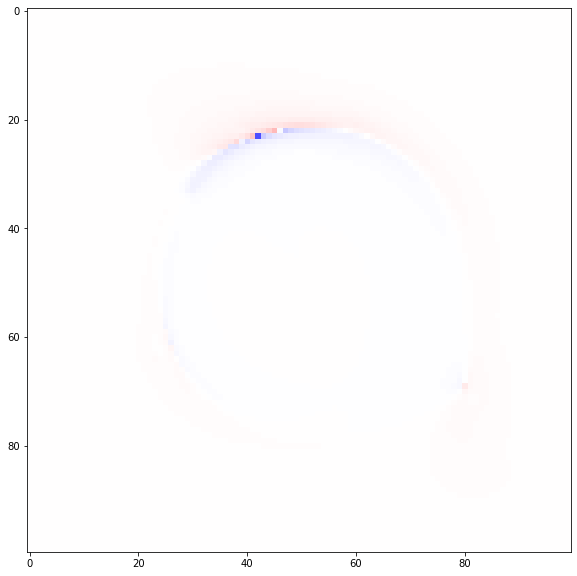

0.6900000000000001


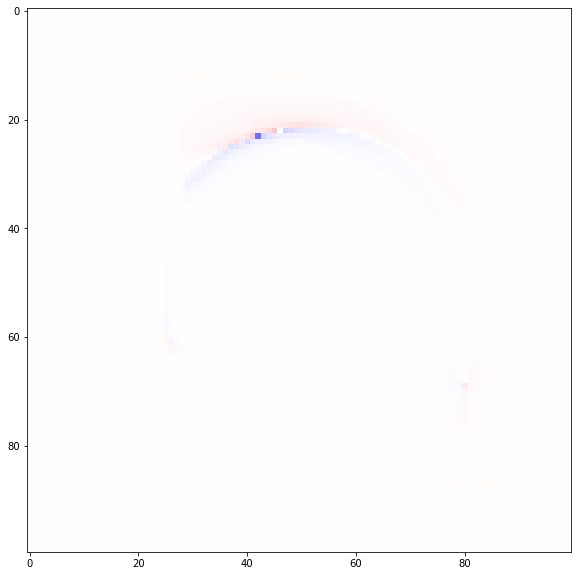

0.7100000000000001


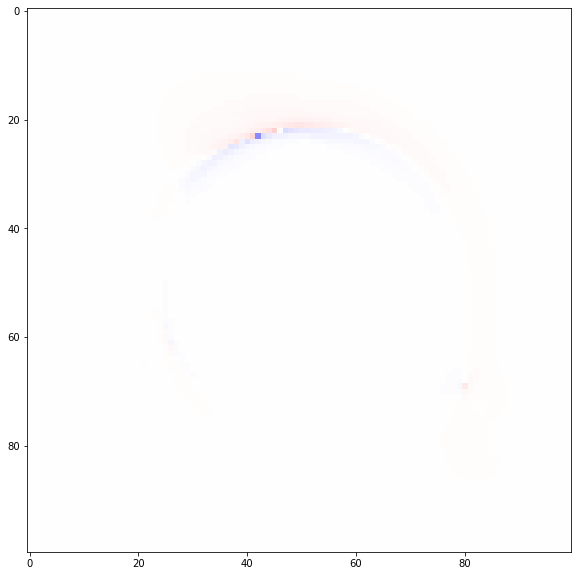

0.73


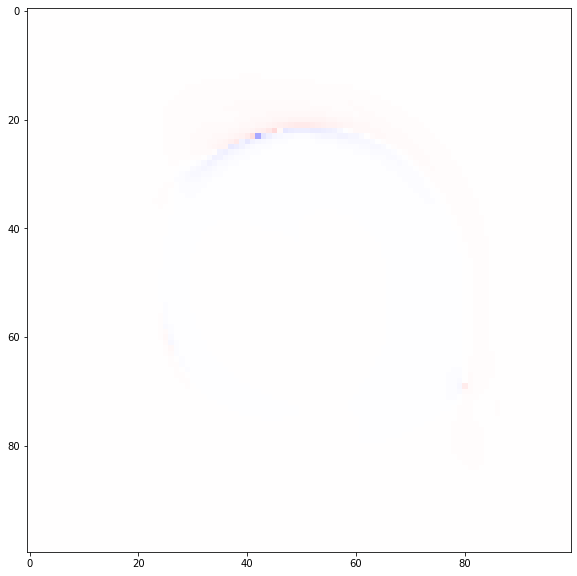

0.75


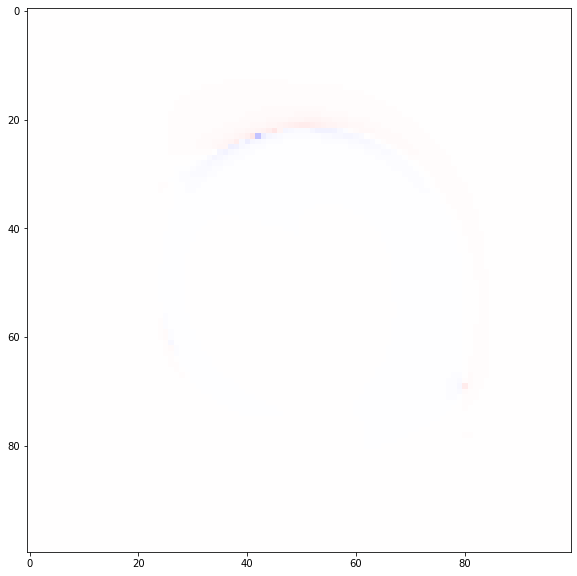

0.77


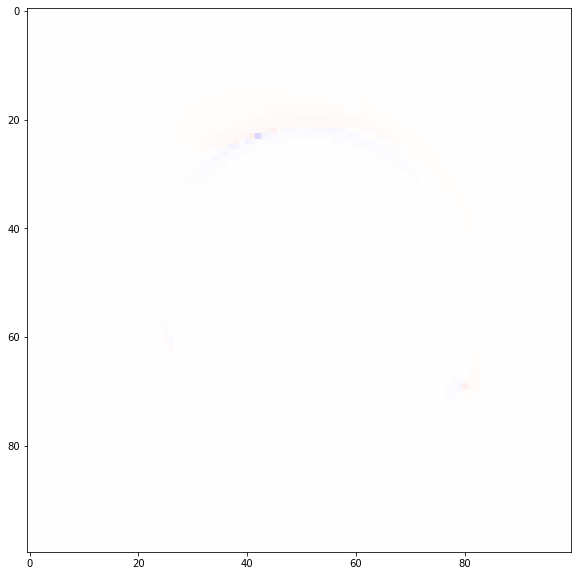

0.79


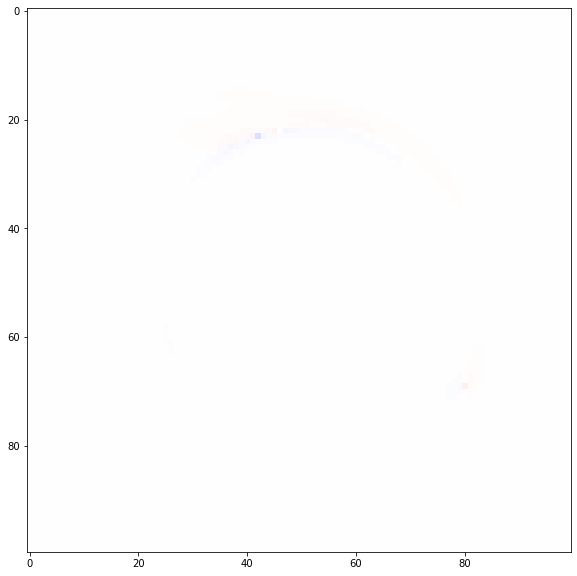

0.81


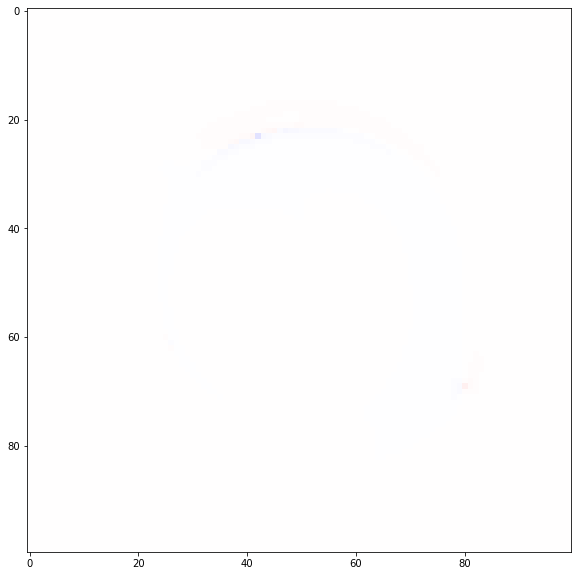

0.8300000000000001


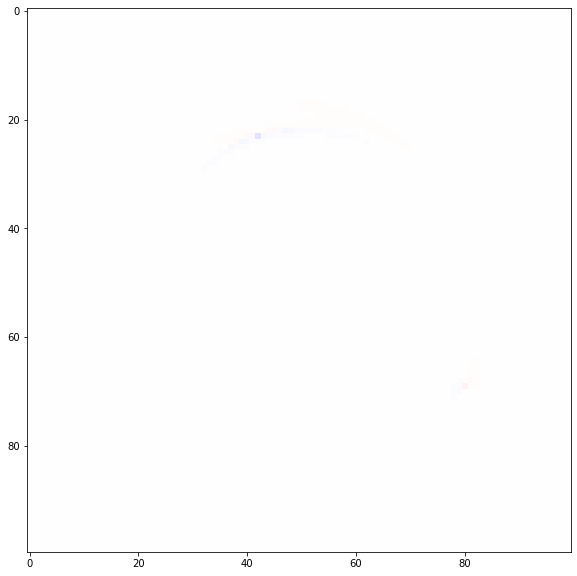

0.85


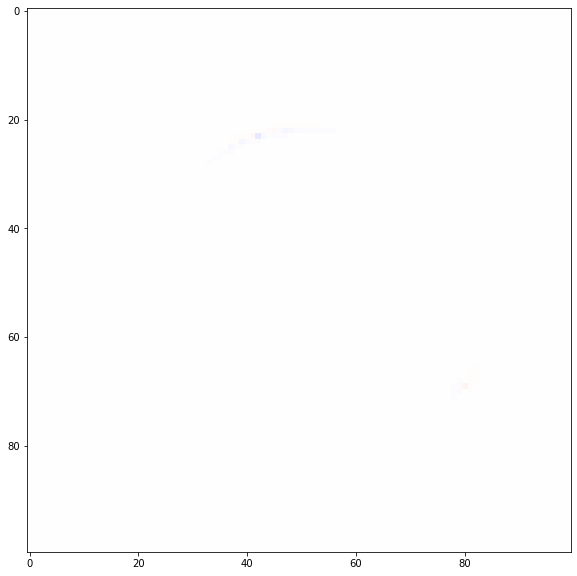

0.87


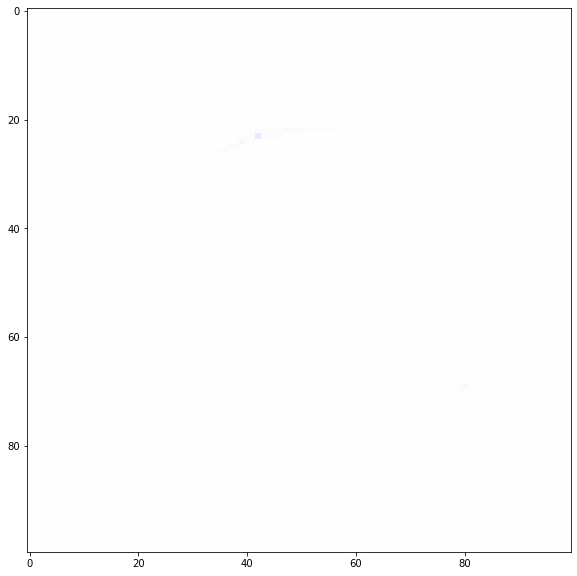

0.89


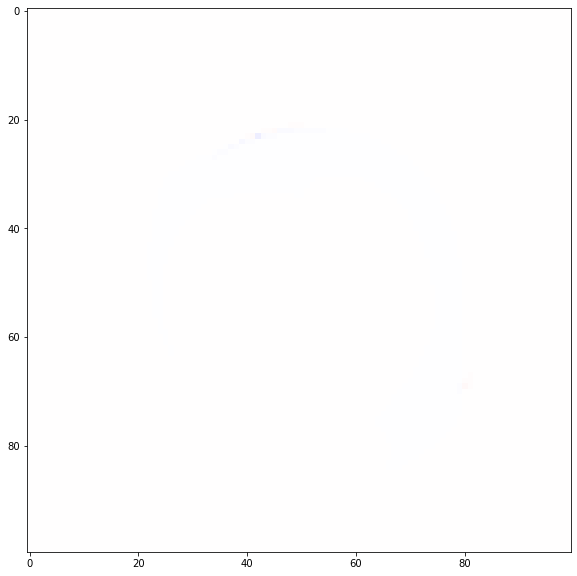

0.91


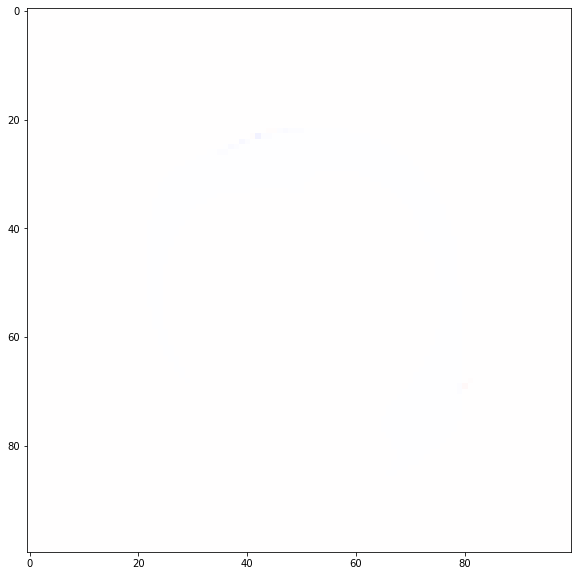

0.93


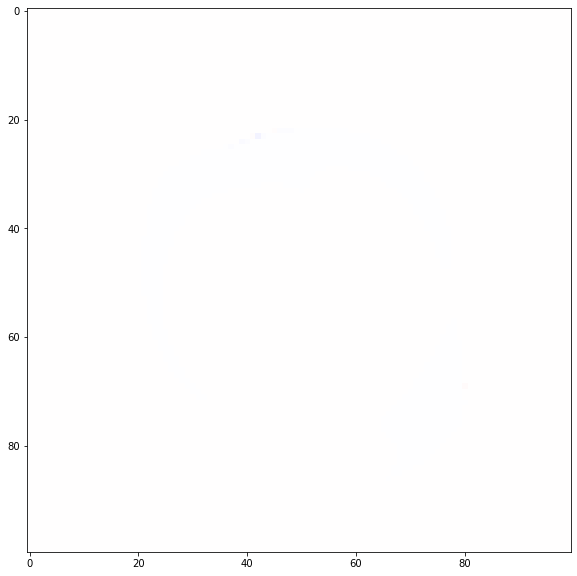

0.9500000000000001


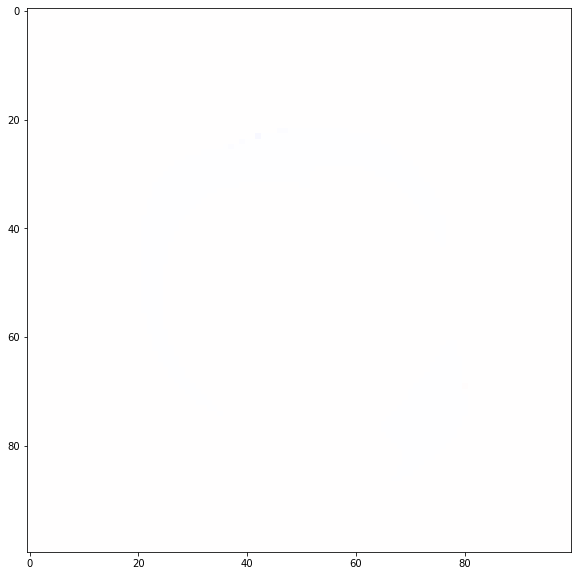

0.97


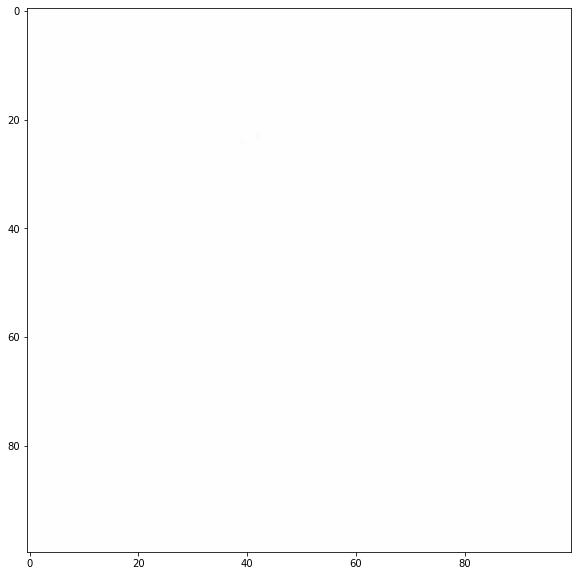

0.99


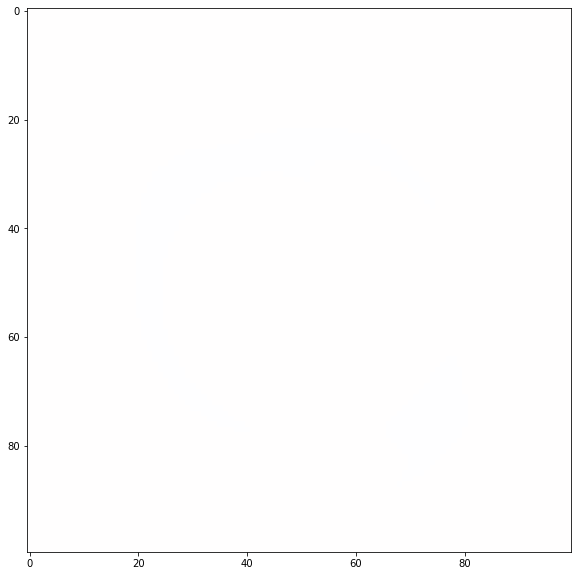

In [24]:
orig_cmap = cms.bwr
for i in range(Nit):
    f, axes = plt.subplots(1, 1, figsize=(10, 10), sharex=False, sharey=False)
    axes.imshow(diff[i][8], cmap=orig_cmap, interpolation='nearest',vmin=-1.,vmax=1.)
    print(zds[i])
    plt.show()